# Del 0 Image and pipeline preprocessing

## Import

In [6]:
# Imports
# Del 0 og 1
# -----------------------------------------------
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
from PIL import Image as img
import math
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import linregress
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.special import binom



# Del 2
# -----------------------------------------------
from sklearn.metrics import silhouette_score
from scipy.signal import find_peaks


# Del 3
# -----------------------------------------------



## Bilde og sekvens definering

In [7]:

BRYGGE_SEKVENS = "./bilder/brygge_sekvens"
BRO_SEKVENS = "./bilder/bro_sekvens"
LAGRA_BILDER = ".bilder/lagra_bilete"
BLANDA_SEKVENS = "./bilder/blanda_sekvens"
RESULT_FOLDER = BRYGGE_SEKVENS

K = np.loadtxt(f"{RESULT_FOLDER}/left/K_matrix.txt")
R = np.loadtxt(f"{RESULT_FOLDER}/left/R_matrix.txt")
T = np.loadtxt(f"{RESULT_FOLDER}/left/T_matrix.txt")

plt.ion()

# Under åpner vi ti = n'te bildet
left_images_filenames = list(filter(lambda fn: fn.split(".")[-1]=="png", os.listdir(f"{RESULT_FOLDER}/left")))
timestamps = list(map(lambda fn: fn.split(".")[0], left_images_filenames))
ti = 0
timestamp = timestamps[ti]
left = cv2.imread(f"{RESULT_FOLDER}/left/{timestamp}.png")
right = cv2.imread(f"{RESULT_FOLDER}/right/{timestamp}.png")
disp = np.array(cv2.imread(f"{RESULT_FOLDER}/disp_zed/{timestamp}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)

print("Første:" ,timestamps[0], " Nærme: ", timestamps[len(timestamps)-1])

def fetch_image(main_as_well=False, RES_FOLDER=RESULT_FOLDER, time=timestamp):

    plt.ion()
    new_main_image = cv2.imread(f"{RES_FOLDER}/left/{time}.png")
    new_main_image = cv2.cvtColor(new_main_image, cv2.COLOR_BGR2RGB)
    new_disparity_image = np.array(cv2.imread(f"{RES_FOLDER}/disp_zed/{time}.png", cv2.IMREAD_ANYDEPTH) / 256.0, dtype=np.float32)
    if(main_as_well):
        return new_disparity_image, new_main_image
    return new_disparity_image

def display_disp_image(to_be_displayed, title="Image", d_type="turbo"):
    plt.figure(figsize=(10, 6))
    plt.imshow(to_be_displayed, cmap=d_type)
    plt.title(title)
    plt.show()

def display_columns_on_image(input_image, col_indices=[500]):
    to_be_displayed = input_image.copy()
    colours = [(255,0,0), (0,255,0), (0,0,255)]
    height = to_be_displayed.shape[0]
    width = to_be_displayed.shape[1]

    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]

        to_be_displayed = cv2.line(to_be_displayed, (col_indices[index],0), (col_indices[index], height), colour, 3)
        #original_image = cv2.line(original_image, dimStart, dimSlutt, colour, 1)


    display_disp_image(to_be_displayed)


# Timestamps
# Første: 1689072599961543541  Nærme:  1689072633388130541 Bru:  1689068851836122093 Båt: 1689068854381001093
Første= 1689072599961543541  
Nærme=  1689072633388130541
Båt =  1689068854381001093
# Fra blanda
KajakkOgBåt = 1689068879500907093
BåtBak = 1689068856993399093
BåtFram = 1689068871596675093
BaderingMann = 1689072623607882541
Badering = 1689072630042776541

 

# Fetch a new current working image and respective disparity
# Dette er disp_første og venstre_første
#current_working_disparity, current_working_image = fetch_image(True)

# Dette er disp_nærme_brygga og nærme_brygga
første_disparity, første_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS ,time=Første)
nærme_disparity, nærme_image = fetch_image(True, RES_FOLDER=BRYGGE_SEKVENS, time=Nærme)
båt_disparity, båt_image = fetch_image(True, RES_FOLDER=BRO_SEKVENS, time=Båt)
kajakk_båt_disparity, kajakk_båt_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=KajakkOgBåt)
båt_bak_disparity, båt_bak_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtBak)
båt_fram_disparity, båt_fram_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BåtFram)
badering_første_disparity, badering_første_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=Badering)
badering_mann_disparity, badering_mann_image = fetch_image(True, RES_FOLDER=BLANDA_SEKVENS ,time=BaderingMann)

standard_fig_size = (10, 6)

all_disparity_images = [første_disparity, nærme_disparity, båt_disparity, kajakk_båt_disparity, båt_bak_disparity, båt_fram_disparity, badering_første_disparity, badering_mann_disparity]



Første: 1689072633388130541  Nærme:  1689072600363349541


### Start metoder og definisjoner

In [8]:

# Dark color definitions with brightness < 128/256
Dark_Red = [100/256, 0, 0]  # Rich, dark red
Dark_Blue = [0, 0, 100/256]  # Deep blue, similar to navy
Dark_Green = [0, 100/256, 0]  # Deep green
Bright_Red = [200/256, 0, 0]  # Bright red
Bright_Green = [0, 200/256, 0]  # Bright green
Bright_Blue = [0, 0, 200/256]  # Bright blue
Dark_Yellow = [128/256, 128/256, 0]  # Muted yellow, darkened
Dark_Purple = [75/256, 0, 130/256]  # Similar to indigo, dark purple
Dark_Orange = [255/256, 140/256, 0]  # Vibrant, but darkened to fit within limits
Dark_Cyan = [0, 139/256, 139/256]  # Rich cyan, darkened
Dark_Magenta = [139/256, 0, 139/256]  # Deep magenta
Charcoal_Gray = [50/256, 50/256, 50/256]  # Dark gray, akin to charcoal
Dark_Lime = [50/256, 205/256, 50/256]  # A darker shade of lime green
Dark_Pink = [255/256, 20/256, 147/256]  # Deep pink, darkened
Dark_Olive = [85/256, 107/256, 47/256]  # Muted, darker olive green
Dark_Turquoise = [0, 206/256, 209/256]  # Deep turquoise
Dark_Brown = [165/256, 42/256, 42/256]  # A rich, dark brown
Dark_Goldenrod = [184/256, 134/256, 11/256] # Dark goldenrod
White = [1, 1, 1]  # White
Black = [0,0,0]
Dark_gray = [0.2,0.2,0.2]
Gray = [0.5,0.5,0.5]

colorScheme = {
    'horizontal1': Bright_Green,
    'horizontal2': Bright_Blue,
    'horizontal3': Dark_Green,
    'horizontal4': Dark_Brown,
    'horizontal5': Dark_Blue,
    'horizontal6': Charcoal_Gray,  # Custom darker teal
    'horizontal7': Dark_Lime,  # Custom dark leaf green
    'vertical1': Bright_Red,
    'vertical2': Dark_Magenta,
    'vertical3': Dark_Yellow,
    'vertical4': Dark_Red,
    'vertical5': Dark_Pink, 
    'vertical6': Dark_Orange,  # Dark Orchid
    'vertical7': Dark_Goldenrod,  # Dark Goldenrod
    'unknown': Dark_gray,  
    'undecided': White,  # White
    'vertical': Bright_Red,
    'horizontal': Bright_Green
}




def interpolate_column(column):
    # Indices of valid and invalid elements
    # Adds the indices of values that are valid meaning real numbers to valid_indices and invalid indices meaning inf, -inf and NaN to 
    valid_mask = np.isfinite(column)
    valid_indices = np.where(valid_mask)[0]
    invalid_indices = np.where(~valid_mask)[0]

    # Check if we have enough data for interpolation
    if len(valid_indices) == 0:
        # No valid data in this column
        return column
    elif len(invalid_indices) == 0:
        # No need for interpolation
        
        return column

    print("PERFORMED INTERPOLATION")
    # Interpolate invalid data points
    valid_data = column[valid_mask]
    column[~valid_mask] = np.interp(invalid_indices, valid_indices, valid_data)
    return column

def interpolate_each_column(input):
    dI = input.copy()
    # Applying the interpolation to each column
    height, width = dI.shape
    for x in range(width):
        dI[:, x] = interpolate_column(dI[:, x])
    return dI

import matplotlib.colors as mcolors

def generate_dark_colors(n):
    # Define the saturation and value for dark colors
    saturation = 1.0  # full saturation for vivid colors
    value = 0.6  # dark enough to ensure good contrast on a white background
    
    # Generate colors
    colors = []
    for i in range(n):
        hue = i / n  # Evenly space hues around the color wheel
        rgb = mcolors.hsv_to_rgb((hue, saturation, value))
        colors.append(rgb)
    
    return colors

def disparity_graphing(disp_map, col_indices=[500], display=False, invert=False):
    
    colours = ['red', 'green', 'blue']

    plt.figure(figsize=standard_fig_size)
    # Extract and plot each column


    for i, col in enumerate(col_indices):
            if(col > disp_map.shape[1]):
                col_indices.pop(i+1)

    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]
        col_data = disp_map[:, col_idx]
        y_values = range(len(col_data))
        plt.plot(col_data, y_values, label=f'Column {index + 1} (Index {col_idx})', color=colour)


    title="Disparity profiles along Column(s) " + str(col_indices)

    # Invert y-axis to match image orientation
    if(invert):
        plt.gca().invert_yaxis()

    # Add labels and legend
    plt.xlabel('Disparity Value')
    plt.ylabel('V-value (rows)')
    plt.title(title)
    plt.legend()

    # Show the plot
    if(display):
        plt.show()

def display_columns_on_image(original_image, col_indices=[500]):
    colours = [(255,0,0), (0,255,0), (0,0,255)]
    height = original_image.shape[0]
    width = original_image.shape[1]

    og_image = original_image.copy()

    for i, col in enumerate(col_indices):
            if(col > og_image.shape[1]):
                print("Cols popped")
                col_indices.pop(i+1)

    title="Columns on original image"


    for index, col_idx in enumerate(col_indices):
        colour = colours[index%3]

        og_image = cv2.line(og_image, (col_indices[index],0), (col_indices[index], height), colour, 3)


    display_disp_image(og_image)

def display_columns_on_image_V2(original_image, col_indices=[500], line_thickness=5, return_image=False):
    # Use a copy of the original image to draw on
    og_image = original_image.copy()
    height = og_image.shape[0]
    width = og_image.shape[1]

    title = "Columns on Original Image"

    # Half the thickness to apply on each side of the column
    half_thickness = line_thickness // 2

    # Iterate over each column index you want to display
    for col_idx in col_indices:
        if col_idx >= width:
            print("Column index out of image bounds:", col_idx)
            continue

        # Calculate the range to apply the thickness
        start_col = max(0, col_idx - half_thickness)
        end_col = min(width, col_idx + half_thickness + 1)

        # Iterate over each pixel in the specified column range
        for row in range(height):
            # Get the brightness of the main column pixel
            main_pixel = og_image[row, col_idx]
            main_brightness = 0.299 * main_pixel[0] + 0.587 * main_pixel[1] + 0.114 * main_pixel[2]

            # Choose the line color based on the main pixel brightness
            if main_brightness < 128:  # Dark pixel, make the line white
                line_color = (255, 255, 255)
            else:  # Light pixel, make the line black
                line_color = (0, 0, 0)

            # Apply this color to the surrounding pixels based on the thickness
            for adj_col in range(start_col, end_col):
                og_image[row, adj_col] = line_color

    # Display the modified image (assuming display_disp_image is a function you have for displaying/saving)
    display_disp_image(og_image, title=title)
    if(return_image):
        return og_image
    return


In [9]:
testing_very_first_methods = False

if(testing_very_first_methods):

    current_disparity_data = nærme_disparity.copy()
    current_image = nærme_image.copy()
    interpolate_each_column(current_disparity_data)
    display_disp_image(current_image, "Original Image")
    display_columns_on_image_V2(current_image,line_thickness=5)
    #display_disp_image(current_disparity_data, "Interpolated Disparity Image")

## Plotting av bilder og disparity profiler

In [10]:
plot_initial_images = True

plot_disparity_graphing = False
testing_image = False

if(testing_image):
    # Testing image
    current_original_image = nærme_image
    current_disparity_data = nærme_disparity
    curr_col = [1250]
    if(plot_disparity_graphing):
        display_columns_on_image(current_original_image, curr_col)
        display_columns_on_image_V2(current_original_image, curr_col)
        disparity_graphing(current_disparity_data, curr_col, display=True, invert=True)
 


if(plot_initial_images):

    
    # Nærme
    print("Nærme")
    #cols_nærme = [730, 1215, 1483]
    cols_nærme = [730, 1215]
    if(plot_disparity_graphing):
        
        display_columns_on_image(nærme_image, cols_nærme)
        display_columns_on_image_V2(nærme_image, cols_nærme)
        disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=False)
        disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=True)


    # Første
    print("Første")
    #cols_første = [550, 1140, 1810]
    cols_første = [550, 1140]
    if(plot_disparity_graphing):
        display_columns_on_image(første_image, cols_første)
        display_columns_on_image_V2(første_image, cols_første)
        disparity_graphing(første_disparity, cols_første, display=True, invert=False)
        disparity_graphing(første_disparity, cols_første, display=True, invert=True)


    # Badering
    print("Badering")
    #cols_badering = [250, 1050, 186]
    cols_badering = [250, 1050]
    if(plot_disparity_graphing): 
        display_columns_on_image(badering_første_image, cols_badering)
        display_columns_on_image_V2(badering_første_image, cols_badering)
        disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=False)
        disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=True)

    # Mann
    print("Mann")
    #cols_mann = [620, 1100, 1880]
    cols_mann = [620, 1100]
    if(plot_disparity_graphing):
        display_columns_on_image(badering_mann_image, cols_mann)
        display_columns_on_image_V2(badering_mann_image, cols_mann)
        disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=False)
        disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=True)

    # Båt
    print("Båt")
    #cols_båt = [340, 585, 800]
    cols_båt = [585, 800]
    if(plot_disparity_graphing):
        display_columns_on_image(båt_image, cols_båt)
        display_columns_on_image_V2(båt_image, cols_båt)
        disparity_graphing(båt_disparity, cols_båt, display=True, invert=False)
        disparity_graphing(båt_disparity, cols_båt, display=True, invert=True)

    # BåtKajakk
    print("BåtKajakk")
    #cols_båtKajakk = [280, 1030, 1250]
    cols_båtKajakk = [280, 1030]
    if(plot_disparity_graphing):
        display_columns_on_image(kajakk_båt_image, cols_båtKajakk)
        display_columns_on_image_V2(kajakk_båt_image, cols_båtKajakk)
        disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=False)
        disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=True)
    
    
    # BåtBak
    print("BåtBak")
    #cols_båtBak = [1100, 1250, 1500]
    cols_båtBak = [1100, 1250]
    if(plot_disparity_graphing):
        display_columns_on_image(båt_bak_image, cols_båtBak)
        display_columns_on_image_V2(båt_bak_image, cols_båtBak)
        disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=False)
        disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=True)

    # BåtFram
    print("BåtFram")
    #cols_båtFram = [500, 600, 1250]
    cols_båtFram = [500, 600]
    if(plot_disparity_graphing):
        display_columns_on_image(båt_fram_image, cols_båtFram)
        display_columns_on_image_V2(båt_fram_image, cols_båtFram)
        disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=False)
        disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=True)

#dI = båt_disparity
#original_image = båt_image

#dI = første_disparity
#original_image = første_image

#dI = nærme_disparity
#original_image = nærme_image

#dI = kajakk_båt_disparity
#original_image = kajakk_båt_image

#dI = båt_bak_disparity
#original_image = båt_bak_image

#dI = båt_fram_disparity
#original_image = båt_fram_image

#dI = badering_første_disparity
#original_image = badering_første_image

#dI = badering_mann_disparity
#original_image = badering_mann_image



Nærme
Første
Badering
Mann
Båt
BåtKajakk
BåtBak
BåtFram


# Del 1 Initial Segmentation

## Main methods for initial segmentation

In [11]:
from scipy.special import binom

n = 30  # Length of the kernel
kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
kernel_binomial = kernel_binomial / np.sum(kernel_binomial) 

DERIVATIVE_MIN = -0.05
DERIVATIVE_MAX = 0.15

# Function to apply low-pass filter to a column
def low_pass_filter(column, K=kernel_binomial, padding=False):

    if(padding):
        # Padding function to repeat edge values
        def pad_with_edge_values(signal, pad_width):
            return np.pad(signal, pad_width, mode='edge')

        # Pad the signal with edge values
        pad_width = n // 2
        column = pad_with_edge_values(column, pad_width)
        filtered_column = np.convolve(column, K, mode='valid')
    # Apply convolution
    else:
        filtered_column = np.convolve(column, K, mode='same')
    return filtered_column

""" # Function to apply low-pass filter to a column
def low_pass_filter(column, K=kernel_binomial):
    # Apply convolution
    filtered_column = np.convolve(column, K, mode='same')
    return filtered_column 
 """

def apply_low_pass_filter(dI, K=kernel_binomial):
    
    height, width = dI.shape
    df = np.zeros_like(dI)  # Low-pass filtered disparity image
    for x in range(width):
        df[:, x] = low_pass_filter(dI[:, x], K=kernel_binomial)

    return df


# Input should be a disparity image where each column is differentiated
def flatten_and_plot_histogram(df_derivative, plot=True,title="Histogram of Derivative Values", input_bins=2000, input_range=(-0.2,0.3), y_lim=(0,80000)):
    # Flatten the array of derivatives to a 1D array
    flattened_derivatives = df_derivative.flatten()

    if(plot):
        # Plot the histogram
        plt.figure(figsize=(10, 6))
        plt.hist(flattened_derivatives, bins=input_bins, range=input_range, color='blue', edgecolor='blue')
        plt.title(title)
        plt.ylim(y_lim)
        plt.xlabel('Derivative Value')
        plt.ylabel('Frequency')
        # Show the plot
        plt.show()
    
    return flattened_derivatives


def take_derivative_diff(df, axe=0):
    print("Diff method")

    # Computing the derivative of each column
    df_derivative = np.diff(df, axis=axe)

    # Padding to handle size difference after np.diff
    df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge')

    return df_derivative



def take_derivative_sobel(df, normalize=True, axe=0):
    print("Sobel method")  

    # Define the 1D Sobel kernelS
    kernel_m = np.array([1, 0, -1])

    # Initialize an array to store the vertical derivative image
    vertical_derivative = np.zeros_like(df)

    # Apply the Sobel kernel to each column
    if(axe==0):
        if(normalize):
            for i in range(df.shape[1]):  # Iterate over columns
                vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same') / 2 
        else:
            for i in range(df.shape[1]):  # Iterate over columns
                vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same')
    else:
        if(normalize):
            for i in range(df.shape[0]):  # Iterate over columns
                vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same') / 2 
        else:
            for i in range(df.shape[0]):  # Iterate over columns
                vertical_derivative[:, i] = np.convolve(df[:, i], kernel_m, mode='same')

    return vertical_derivative


## Clustering
def clustering(flattened_derivatives, a_mini=-0.3, a_maxi=0.5, clusters=2):
    # Clipping the data to be between -0.3 and 0.5
    clipped_derivatives = np.clip(flattened_derivatives, a_min=a_mini, a_max=a_maxi)

    clipped_derivatives = clipped_derivatives[(clipped_derivatives > a_mini) & (clipped_derivatives < a_maxi)]
    # Reshape data for KMeans
    clustering_model = clipped_derivatives.reshape(-1, 1)

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=clusters, init='k-means++', n_init='auto')
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    return clustering_model, clipped_derivatives, labels, centers

def plot_clusters(clustering_model, labels, input_range=(-0.05, 0.15)):
    cluster1 = clustering_model[labels == 0]
    cluster2 = clustering_model[labels == 1]

    plt.figure(figsize=(10, 6))
    plt.hist(cluster1, bins=200, range=input_range, density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Cluster 1')
    plt.legend()
    plt.show()

    # Plot histogram 
    plt.figure(figsize=(10, 6))
    plt.hist(cluster2, bins=200, range=input_range, density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Cluster 2')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(clustering_model, bins=200, range=input_range, density=True, alpha=0.6)
    plt.xlabel('Derivative Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of both clusters')
    plt.legend()
    plt.show()

# Gaussian fit function
def fit_gaussian(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return mean, stddev

def fit_clusters(clustering_model, labels):
    cluster1 = clustering_model[labels == 0]
    cluster2 = clustering_model[labels == 1]
    mean1, stddev1 = fit_gaussian(cluster1)
    mean2, stddev2 = fit_gaussian(cluster2)

    return mean1, mean2, stddev1, stddev2

def gaussian_curve(x, mean, stddev):
    return (1 / (stddev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / stddev) ** 2)


def cluster_threshold_method(clustering_model, labels, clipped_derivatives, k=1, plot=True, input_range=(-0.1, 0.2)):
    mean1, mean2, stddev1, stddev2 = fit_clusters(clustering_model, labels)
    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
        red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1
        red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'


    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev

    if(plot):
        print("NÅ ER VI HER")
        # Create a range of x values
        x_values = np.linspace(-0.25, 0.45, 400)

        # Gaussian curves
        gaussian_curve1 = gaussian_curve(x_values, mean1, stddev1)
        gaussian_curve2 = gaussian_curve(x_values, mean2, stddev2)

        cluster1 = clustering_model[labels == 0]
        cluster2 = clustering_model[labels == 1]
        #x_min, x_max = -5, 5
        #plt.xlim(x_min, x_max)
        x_min, x_max = input_range[0], input_range[1]

        # Plot histogram and Gaussian curves
        plt.figure(figsize=(10, 6))
        plt.hist(cluster1, bins=400, range=input_range, density=True, alpha=0.6)
        plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
        plt.xlabel('Derivative Values')
        plt.ylabel('Frequency')
        plt.xlim(x_min, x_max)
        plt.title('Histogram with Fitted Gaussian Curves')
        plt.legend()
        plt.show()

        # Plot histogram and Gaussian curves
        plt.figure(figsize=(10, 6))
        plt.hist(cluster2, bins=400, range=input_range, density=True, alpha=0.6)
        plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
        plt.xlabel('Derivative Values')
        plt.ylabel('Frequency')
        plt.xlim(x_min, x_max)
        plt.title('Histogram with Fitted Gaussian Curves')
        plt.legend()
        plt.show()

        # Plot histogram and Gaussian curves
        plt.figure(figsize=(10, 6))
        plt.hist(clipped_derivatives, bins=400, range=input_range, density=True, alpha=0.6)
        plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
        plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
        plt.xlabel('Derivative Values')
        plt.ylabel('Frequency')
        plt.xlim(x_min, x_max)
        plt.title('Histogram with Fitted Gaussian Curves')
        plt.legend()
        plt.show()
        
    return red_dL, red_dU, green_dL, green_dU

# NOT IN USE
""" def thresholds_3_gaussians(flattened_derivatives, min_clip=-0.3, max_clip = 0.5, bins = 200, plot=True, k=2):
    num_curves = 3

    # Example flattened_derivatives - replace with your actual data
    # flattened_derivatives = ...

    # Clip the data between -0.3 and 0.6
    clipped_derivatives = np.clip(flattened_derivatives, min_clip, max_clip)

    # Removing extreme values
    filtered_data = clipped_derivatives[(clipped_derivatives > min_clip) & (clipped_derivatives < max_clip)]
    clipped_derivatives = filtered_data

    # Fit a Gaussian Mixture Model with 2 components to the data
    gmm = GaussianMixture(n_components=num_curves, random_state=0)
    #gmm = GaussianMixture(n_components=2, random_state=0, init_params='kmeans++')

    gmm.fit(clipped_derivatives.reshape(-1, 1))

    # Extract the means, covariances, and weights of the two Gaussians
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    std_devs = np.sqrt(covariances)
    weights = gmm.weights_.flatten()

    if(plot):
        # Create a range of x values for plotting
        x_values = np.linspace(min_clip, max_clip, 400)
        # Calculate the individual Gaussians' PDFs
        gaussian_pdfs = [
            weights[i] * norm.pdf(x_values, means[i], np.sqrt(covariances[i]))
            for i in range(2)
        ]

        # Plot the histogram of the clipped data
        plt.figure(figsize=(10, 6))
        plt.hist(clipped_derivatives, bins=bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='g', label='Data Histogram')

        # Plot each Gaussian PDF
        for i, pdf in enumerate(gaussian_pdfs):
            plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means[i]:.2f}, SD: {np.sqrt(covariances[i]):.2f})')

        plt.legend()
        plt.title('Histogram with Individual Fitted Gaussian Distributions')
        plt.xlabel('Data Value')
        plt.ylabel('Density')

        plt.show()
    
    mean1 = means[0]
    mean2 = means[1]
    stddev1 = std_devs[0]
    stddev2 = std_devs[1]

    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
        red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1
        red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'

    # Below are the upper and lower bounds
    # Assuming you have mean1, stddev1, mean2, stddev2 from the Gaussian fits


    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev


    return red_dL, red_dU, green_dL, green_dU """

def thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=2, num_bins=400,p=0.01, k=2, plot=True, version=1, clip="reclip", perform_crop=True):
    print("Thresholds Clipping version")

    clipped_derivatives = np.clip(flattened_derivatives, min_clip, max_clip)
    clipped_derivatives = clipped_derivatives[(clipped_derivatives > min_clip) & (clipped_derivatives < max_clip)]

    hist_values, bin_edges = np.histogram(clipped_derivatives, bins=num_bins, density=True)

    peaks, _ = find_peaks(hist_values)

    # If there are at least two peaks, find the second largest
    
    sorted_peaks = sorted(peaks, key=lambda x: hist_values[x], reverse=True)
    largest_peak = sorted_peaks[0]
    second_largest_peak = sorted_peaks[1]

    largest_mode = bin_edges[largest_peak]
    second_largest_mode = bin_edges[second_largest_peak]
    
    largest_frequency = hist_values[largest_peak]
    second_largest_frequency = hist_values[second_largest_peak]
    
    print("Largest mode:", largest_mode)
    print("Second largest mode:", second_largest_mode)
    print("Frequency of the largest mode:", largest_frequency)
    print("Frequency of the second largest mode:", second_largest_frequency)
   
    if(abs(largest_mode) <0.01):
        print("Sky peak present")
        threshold = p * second_largest_frequency
    else:
        print("Small sky peak only")
        threshold = p * largest_frequency
    if(plot):
        print("Maximum frequency in the histogram:", second_largest_frequency)
        print(f"Threshold ({p*100}% of second largest frequency):", threshold)

    # Adjust histogram values: set values below the threshold to 0
    smooth_hist_values = np.where(hist_values < threshold, 0, hist_values)    

    if(clip == "absolute"):
        print("Reclipping absolute version")
        reclipped_derivatives = clipped_derivatives[(clipped_derivatives > DERIVATIVE_MIN) & (clipped_derivatives < DERIVATIVE_MAX)]
    elif(clip == "regular"):
        print("Regular clipping")
        reclipped_derivatives = clipped_derivatives
    else:
        print("Reclipping percentage version")
        # Find the indices of non-zero bins in the smoothed histogram 
        non_zero_indices = np.nonzero(smooth_hist_values)[0]

        mask = np.zeros_like(clipped_derivatives, dtype=bool)

        # Loop over non-zero bins to create the mask
        for idx in non_zero_indices:
            mask |= (clipped_derivatives >= bin_edges[idx]) & (clipped_derivatives < bin_edges[idx + 1])

        # Apply the mask to get reclipped derivatives
        reclipped_derivatives = clipped_derivatives[mask]
        """ 
        # Extract the minimum and maximum value along the value axis
        min_value_range = bin_edges[non_zero_indices[0]]
        max_value_range = bin_edges[non_zero_indices[-1] + 1]  # Add 1 to include the right edge of the last bin
        reclipped_derivatives = clipped_derivatives[(clipped_derivatives > min_value_range) & (clipped_derivatives < max_value_range)]  
        """

    x_min=-0.10    
    x_max=0.20
    max_y = 80

    if(plot):
        # Plot the adjusted histogram
        plt.figure(figsize=(10, 6))
        #bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Calculate bin centers for plotting
        #plt.bar(bin_centers, smooth_hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Smoothed Histogram')
        if(perform_crop):
            plt.hist(reclipped_derivatives, bins=num_bins, range=(x_min, x_max), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
        else:
            plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
        plt.legend()
        plt.title('Smoothed Histogram of Clipped Derivatives')
        plt.xlabel('Derivatives')
        plt.ylabel('Frequency')

        plt.show()
        
    # Fit a Gaussian Mixture Model with 2 components to the data
    gmm = GaussianMixture(n_components=num_curves, random_state=0)
    gmm.fit(reclipped_derivatives.reshape(-1, 1))

    # Extract the means, covariances, and weights of the two Gaussians
    means = gmm.means_.flatten()
    covariances = gmm.covariances_.flatten()
    std_devs = np.sqrt(covariances)
    weights = gmm.weights_.flatten()
    if(plot):
        print("means: ", means)
        print("std_devs: ", std_devs)
        print("weights: ", weights)


    if(plot):
        # Create a range of x values for plotting
        x_values = np.linspace(min_clip, max_clip, 400)

        # Calculate the individual Gaussians' PDFs
        gaussian_pdfs = [
            weights[i] * norm.pdf(x_values, means[i], np.sqrt(covariances[i]))            
            #norm.pdf(x_values, means[i], np.sqrt(covariances[i]))

            for i in range(num_curves)
        ]

        # Plot the histogram of the clipped data
        plt.figure(figsize=(10, 6))
        if(perform_crop):
            plt.hist(reclipped_derivatives, bins=num_bins, range=(x_min, x_max), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
        else:
            plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
        # Plot each Gaussian PDF
        for i, pdf in enumerate(gaussian_pdfs):
            plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means[i]:.2f}, SD: {np.sqrt(covariances[i]):.2f})')
            if(perform_crop):
                plt.xlim(x_min, x_max)
        plt.legend()
        plt.title('Histogram with Individual Fitted Gaussian Distributions')
        plt.xlabel('Derivatives')
        plt.ylabel('Frequency')

        plt.show()

    

    mean1 = means[0]
    mean2 = means[1]
    stddev1 = std_devs[0]
    stddev2 = std_devs[1]


    if(version==1):
        print("Returning thresholds")
        # Determine which mean is closer to 0 and assign labels
        if abs(mean1) < abs(mean2):
            red_mean, green_mean = mean1, mean2
            red_stddev, green_stddev = stddev1, stddev2
            red_label, green_label = 'Cluster 1 (Red)', 'Cluster 2 (Green)'
        else:
            red_mean, green_mean = mean2, mean1
            red_stddev, green_stddev = stddev2, stddev1
            red_label, green_label = 'Cluster 2 (Red)', 'Cluster 1 (Green)'


        red_dL = red_mean - k * red_stddev
        red_dU = red_mean + k * red_stddev
        green_dL = green_mean - k * green_stddev
        green_dU = green_mean + k * green_stddev

        return red_dL, red_dU, green_dL, green_dU
    else:
        print("Returning means and standard deviations")
        print("Mean1:", mean1,  "Stddev1:", stddev1)
        print("Mean2:", mean2, "Stddev2:", stddev2)
        return mean1, mean2, stddev1, stddev2 

def gaussian_likelihood(x, mu, sigma):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def compute_likelihood_ratio(x, mu1, mu2, sigma1, sigma2, only_return_ratio=True):
    P_x_gaussian1 = gaussian_likelihood(x, mu1, sigma1)
    P_x_gaussian2 = gaussian_likelihood(x, mu2, sigma2)
    L_x = P_x_gaussian1 / P_x_gaussian2

    if(only_return_ratio):
        return L_x
    return L_x, P_x_gaussian1, P_x_gaussian2

# And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians
def classify_points(df_derivative, mean1, mean2, stddev1, stddev2, k=2, include_undecided_label=True, likelihood_range=(0.5,2)):
    print("Classify and colour version 2")
    # Determine which mean is closer to 0 and assign labels
    if abs(mean1) < abs(mean2):
        red_mean, green_mean = mean1, mean2
        red_stddev, green_stddev = stddev1, stddev2
    else:
        red_mean, green_mean = mean2, mean1
        red_stddev, green_stddev = stddev2, stddev1

    print("Red mean:", red_mean, " Red stddev:", red_stddev)
    print("Green mean:", green_mean, " Green stddev:", green_stddev)
    
    print("K value:", k)
    red_dL = red_mean - k * red_stddev
    red_dU = red_mean + k * red_stddev
    green_dL = green_mean - k * green_stddev
    green_dU = green_mean + k * green_stddev
   
    classification_map = np.empty(df_derivative.shape, dtype=object)

    if include_undecided_label:
        print("includes undecided")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    #print("Undecided!!")
                    ratio, red_likelihood, green_likelihood  = compute_likelihood_ratio(derivative_value, red_mean, green_mean, red_stddev, green_stddev, False)
                    #print("Ratio: ", ratio)
                    if(likelihood_range[0] <= ratio <= likelihood_range[1]):
                        classification = 'undecided'
                    elif red_likelihood > green_likelihood:
                        classification = 'vertical' 
                    else:
                        classification = 'horizontal'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification
    else:
        print("Undecided and unknown is the same")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    classification = 'unknown'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification

    return classification_map



# And dL1, dU1, dL2, dU2 are the range limits for the two Gaussians
def classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU, include_undecided_label=True):
    print("Classify and colour")

    classification_map = np.empty(df_derivative.shape, dtype=object)

    if include_undecided_label:
        print("includes undecided")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    print("UNDECIDED")
                    classification = 'undecided'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification
    else:
        print("Undecided and unknown is the same")
        for i in range(df_derivative.shape[0]):  # Rows
            for j in range(df_derivative.shape[1]):  # Columns
                derivative_value = df_derivative[i, j]

                # Check if the derivative value falls into the range of either Gaussian
                if (red_dL <= derivative_value <= red_dU) and (green_dL <= derivative_value <= green_dU):
                    classification = 'unknown'
                elif red_dL <= derivative_value <= red_dU:
                    classification = 'vertical'  # Red cluster
                elif green_dL <= derivative_value <= green_dU:
                    classification = 'horizontal'  # Green cluster
                else:
                    classification = 'unknown'

                classification_map[i, j] = classification

    return classification_map
    
def assign_colours_and_plot(classification_map, colors=colorScheme, plot=True, title="Pixel-wise Disparity Map Classification"):
    # Create an empty array for the color-coded image
    color_coded_image = np.zeros((*classification_map.shape, 3))

    # Assign colors
    for classification, color in colors.items():
        mask = classification_map == classification
        color_coded_image[mask] = color

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.imshow(color_coded_image)
        plt.title(title)
        plt.axis('off')  # Hide the axes
        plt.show()
    
    return color_coded_image





## Initial segmentation pipeline


### Full pipeline methods

In [12]:
def initial_segmentation(original_image, dI, number_of_curves=2, p_val=0.1, k_value=3, clustering_bool=False, plot_figures=True, clipping="reclip", perform_crop=True):
    print("Initial segmentation")
    if(clustering_bool):
        k_value = 1
    else:
        curves = number_of_curves
        input_bins=200
    # Interpolate
    dI = interpolate_each_column(dI)

    # Low-pass filter
    df = apply_low_pass_filter(dI)


    # Take the derivative
    #df_derivative = take_derivative_diff(df)
    #df_derivative = take_derivative_sobel(df, normalize=False)
    #df_derivative = take_derivative_sobel(df)
    df_derivative = take_derivative_diff(df)

    # Flatten the derivatives for clustering
    flattened_derivatives = flatten_and_plot_histogram(df_derivative, plot=False, title="Histogram of the derivatives")

    # Clustering method
    if(clustering_bool):
        print("Clustering method")
        clustering_model, clipped_derivatives, labels, centers = clustering(flattened_derivatives)
        if(plot_figures):
            plot_clusters(clustering_model, labels)
        red_dL,red_dU, green_dL, green_dU = cluster_threshold_method(clustering_model, labels, clipped_derivatives, k=k_value, plot=plot_figures)
        classification_map = classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU)


    # Gaussian mixtures method
    else:
        print("Gaussian mixtures method")
        #red_dL, red_dU, green_dL, green_dU = thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=2, num_bins=200,p=0.01, k=2.5, plot=True)
        #classification_map = classify_points_obsolete(df_derivative, red_dL, red_dU, green_dL, green_dU)

        mean1, mean2, stddev1, stddev2 = thresholds_reclipping(flattened_derivatives, min_clip=-0.3, max_clip=0.5, num_curves=curves, num_bins=input_bins,p=p_val, k=k_value, plot=plot_figures, version=2, clip=clipping, perform_crop=perform_crop)
        classification_map = classify_points(df_derivative, mean1, mean2, stddev1, stddev2, k=k_value)


    # Original image
    if(plot_figures):
        display_disp_image(original_image, title="Original Image")

    # Plot colorized image
    colored_image = assign_colours_and_plot(classification_map, title="Horizontal and vertical pixel segmentation", plot=plot_figures)

    if(plot_figures):
        display_disp_image(colored_image)

    return classification_map, colored_image, df_derivative


def derivative_and_histogram(dI, plot=True, title="Histogram of the derivatives", range=(-0.2,0.3), y_lim=(0,80000)):
    dI = interpolate_each_column(dI)

    # Low-pass filter
    df = apply_low_pass_filter(dI)

    df_derivative = take_derivative_diff(df)

    
    # Flatten the derivatives for clustering
    flattened_derivatives = flatten_and_plot_histogram(df_derivative, plot=plot, title=title, input_range=range, y_lim=y_lim)

    return df_derivative, flattened_derivatives
    
def return_image_to_be_used(current_image_number=1):

    if(current_image_number == 1):
        print("Using nærme image")
        dI = nærme_disparity
        original_image = nærme_image
    #dI = båt_disparity
    #original_image = båt_image

    elif(current_image_number == 2):
        print("Using første image")
        dI = første_disparity
        original_image = første_image
    #dI = første_disparity
    #original_image = første_image


    elif(current_image_number == 3):
        print("Using badering_første image")
        dI = badering_første_disparity
        original_image = badering_første_image
    #dI = nærme_disparity
    #original_image = nærme_image


    elif(current_image_number == 4):
        print("Using badering_mann image")
        dI = badering_mann_disparity
        original_image = badering_mann_image
    #dI = kajakk_båt_disparity
    #original_image = kajakk_båt_image


    elif(current_image_number == 5):
        print("Using båt image")
        dI = båt_disparity
        original_image = båt_image

        
    #dI = båt_bak_disparity
    #original_image = båt_bak_image


    elif(current_image_number == 6):
        print("Using kajakk_båt image")
        dI = kajakk_båt_disparity
        original_image = kajakk_båt_image
        
    #dI = båt_fram_disparity
    #original_image = båt_fram_image


    elif(current_image_number == 7):
        print("Using båt_bak image")
        dI = båt_bak_disparity
        original_image = båt_bak_image
    #dI = badering_første_disparity
    #original_image = badering_første_image


    elif(current_image_number == 8):
        print("Using båt_fram image")
        dI = båt_fram_disparity
        original_image = båt_fram_image
    else:
        print("Using båt image")
        dI = båt_disparity
        original_image = båt_image

    return original_image, dI
    #dI = badering_mann_disparity
    #original_image = badering_mann_image

### Run pipeline

In [ ]:
current_image_number = 5
init_segment_all_test_images = False

# ----------------------------------------------------------------------------
#Full method above
# ----------------------------------------------------------------------------
# Clippings can be: "absolute", "regular", "reclip"
percentage = 0.1
run_bridge_sequence=True
run_dock_sequence=True


if(init_segment_all_test_images):
    if(run_bridge_sequence):
        for i in range(5,9):
            print("Image number: ", i)
            original_image, dI = return_image_to_be_used(i)
            class_map, colored_image, _ = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=True, clipping="reclip", perform_crop=True)
    
    if(run_dock_sequence):
        for i in range(1,5):
            print("Image number: ", i)
            original_image, dI = return_image_to_be_used(i)
            class_map, colored_image, _ = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=True, clipping="reclip", perform_crop=True)


else:
    print("Image number: ", current_image_number)
    original_image, dI = return_image_to_be_used(current_image_number)

    class_map, colored_image, _ = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=True, clipping="reclip", perform_crop=True)


### Plottings and runs on all images

In [13]:
plot_initial_images = True

# For disparity graphing
plot_disparity_graphing = False
testing_image = False

# For histogram plotting
plot_histograms_for_all = False
histi_range = (-0.05,0.15)
#y_limit = (0, 80000)    # (0, 80000)
include_y_limit = False


# For initial segmentation
perform_initial_segmentation = True
perform_clustering = False
plot_each_separately = False
perform_reclipping = False

if(testing_image):
    # Testing image
    current_original_image = nærme_image
    current_disparity_data = nærme_disparity
    curr_col = [1250]
    if(plot_disparity_graphing):
        display_columns_on_image(current_original_image, curr_col)
        display_columns_on_image_V2(current_original_image, curr_col)
        disparity_graphing(current_disparity_data, curr_col, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map, colored_image, _ = initial_segmentation(current_original_image, current_disparity_data, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(current_disparity_data, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(current_disparity_data, plot=True, title="Histogram of the derivatives", range=histi_range)
       


if(plot_initial_images):

    
    # Nærme
    print("Nærme")
    #cols_nærme = [730, 1215, 1483]
    cols_nærme = [730, 1215]
    if(plot_disparity_graphing):
        
        display_columns_on_image(nærme_image, cols_nærme)
        display_columns_on_image_V2(nærme_image, cols_nærme)
        disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=False)
        disparity_graphing(nærme_disparity, cols_nærme, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map_nærme, colored_image_nærme, derivatives_nærme = initial_segmentation(nærme_image, nærme_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(nærme_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
            print("Shouldnt be here")
        else:
            derivative_and_histogram(nærme_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)

    # Første
    print("Første")
    #cols_første = [550, 1140, 1810]
    cols_første = [550, 1140]
    if(plot_disparity_graphing):
        display_columns_on_image(første_image, cols_første)
        display_columns_on_image_V2(første_image, cols_første)
        disparity_graphing(første_disparity, cols_første, display=True, invert=False)
        disparity_graphing(første_disparity, cols_første, display=True, invert=True)
    if(perform_initial_segmentation):  
        class_map_første, colored_image_første, derivatives_første = initial_segmentation(første_image, første_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(første_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(første_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)

    # Badering
    print("Badering")
    #cols_badering = [250, 1050, 186]
    cols_badering = [250, 1050]
    if(plot_disparity_graphing): 
        display_columns_on_image(badering_første_image, cols_badering)
        display_columns_on_image_V2(badering_første_image, cols_badering)
        disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=False)
        disparity_graphing(badering_første_disparity, cols_badering, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map_badering, colored_image_badering, derivatives_badering = initial_segmentation(badering_første_image, badering_første_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(badering_første_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(badering_første_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)
    # Mann
    print("Mann")
    #cols_mann = [620, 1100, 1880]
    cols_mann = [620, 1100]
    if(plot_disparity_graphing):
        display_columns_on_image(badering_mann_image, cols_mann)
        display_columns_on_image_V2(badering_mann_image, cols_mann)
        disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=False)
        disparity_graphing(badering_mann_disparity, cols_mann, display=True, invert=True)
    if(perform_initial_segmentation):   
        class_map_mann, colored_image_mann, derivatives_mann = initial_segmentation(badering_mann_image, badering_mann_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(badering_mann_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)    
        else:
            derivative_and_histogram(badering_mann_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)



    # Båt
    print("Båt")
    #cols_båt = [340, 585, 800]
    cols_båt = [585, 800]
    if(plot_disparity_graphing):
        display_columns_on_image(båt_image, cols_båt)
        display_columns_on_image_V2(båt_image, cols_båt)
        disparity_graphing(båt_disparity, cols_båt, display=True, invert=False)
        disparity_graphing(båt_disparity, cols_båt, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map_båt, colored_image_båt, derivatives_båt = initial_segmentation(båt_image, båt_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):    
        if(include_y_limit):    
            derivative_and_histogram(båt_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(båt_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)




    # BåtKajakk
    print("BåtKajakk")
    #cols_båtKajakk = [280, 1030, 1250]
    cols_båtKajakk = [280, 1030]
    if(plot_disparity_graphing):
        display_columns_on_image(kajakk_båt_image, cols_båtKajakk)
        display_columns_on_image_V2(kajakk_båt_image, cols_båtKajakk)
        disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=False)
        disparity_graphing(kajakk_båt_disparity, cols_båtKajakk, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map_kajakk_båt, colored_image_kajakk_båt, derivatives_kajakk_båt = initial_segmentation(kajakk_båt_image, kajakk_båt_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(kajakk_båt_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(kajakk_båt_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)





    # BåtBak
    print("BåtBak")
    #cols_båtBak = [1100, 1250, 1500]
    cols_båtBak = [1100, 1250]
    if(plot_disparity_graphing):
        display_columns_on_image(båt_bak_image, cols_båtBak)
        display_columns_on_image_V2(båt_bak_image, cols_båtBak)
        disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=False)
        disparity_graphing(båt_bak_disparity, cols_båtBak, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map_båt_bak, colored_image_båt_bak, derivatives_båt_bak = initial_segmentation(båt_bak_image, båt_bak_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(båt_bak_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(båt_bak_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)



    # BåtFram
    print("BåtFram")
    #cols_båtFram = [500, 600, 1250]
    cols_båtFram = [500, 600]
    if(plot_disparity_graphing):
        display_columns_on_image(båt_fram_image, cols_båtFram)
        display_columns_on_image_V2(båt_fram_image, cols_båtFram)
        disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=False)
        disparity_graphing(båt_fram_disparity, cols_båtFram, display=True, invert=True)
    if(perform_initial_segmentation):
        class_map_båt_fram, colored_image_båt_fram, derivatives_båt_fram = initial_segmentation(båt_fram_image, båt_fram_disparity, clustering_bool=perform_clustering, plot_figures=plot_each_separately, clipping=perform_reclipping)
    if(plot_histograms_for_all):
        if(include_y_limit):
            derivative_and_histogram(båt_fram_disparity, plot=True, title="Histogram of the derivatives", range=histi_range, y_lim=y_limit)
        else:
            derivative_and_histogram(båt_fram_disparity, plot=True, title="Histogram of the derivatives", range=histi_range)


    if(perform_initial_segmentation):
        all_class_maps = [class_map_nærme, class_map_første, class_map_badering, class_map_mann, class_map_båt, class_map_kajakk_båt, class_map_båt_bak, class_map_båt_fram]
        all_colored_images = [colored_image_nærme, colored_image_første, colored_image_badering, colored_image_mann, colored_image_båt, colored_image_kajakk_båt, colored_image_båt_bak, colored_image_båt_fram]
        all_derivatives = [derivatives_nærme, derivatives_første, derivatives_badering, derivatives_mann, derivatives_båt, derivatives_kajakk_båt, derivatives_båt_bak, derivatives_båt_fram]
        print("All initial segmentations done")

#dI = båt_disparity
#original_image = båt_image

#dI = første_disparity
#original_image = første_image

#dI = nærme_disparity
#original_image = nærme_image

#dI = kajakk_båt_disparity
#original_image = kajakk_båt_image

#dI = båt_bak_disparity
#original_image = båt_bak_image

#dI = båt_fram_disparity
#original_image = båt_fram_image

#dI = badering_første_disparity
#original_image = badering_første_image

#dI = badering_mann_disparity
#original_image = badering_mann_image



Nærme
Initial segmentation
Diff method
Gaussian mixtures method
Thresholds Clipping version
Largest mode: -0.0039646626
Second largest mode: 0.072027564
Frequency of the largest mode: 26.732047035331693
Frequency of the second largest mode: 13.03015824269232
Sky peak present
Reclipping percentage version
Returning means and standard deviations
Mean1: 0.0026874672778027715 Stddev1: 0.011185647163285451
Mean2: 0.07437713888669706 Stddev2: 0.01612676281742148
Classify and colour version 2
Red mean: 0.0026874672778027715  Red stddev: 0.011185647163285451
Green mean: 0.07437713888669706  Green stddev: 0.01612676281742148
K value: 3
includes undecided
Første
Initial segmentation
Diff method
Gaussian mixtures method
Thresholds Clipping version
Largest mode: -0.0039578485
Second largest mode: 0.07203515
Frequency of the largest mode: 19.93692171261164
Frequency of the second largest mode: 14.218899226035465
Sky peak present
Reclipping percentage version
Returning means and standard deviations


## Derivatives and testing

### Visualization of kernels and testing

In [ ]:
plot_visualization_of_kernels= False
plot_disparity_profiles_after_kernels = False
standard_n = 15

In [ ]:
#column_index = disparity_map.shape[1] // 2
if(plot_visualization_of_kernels):
    disparity_map = første_disparity.copy()
    disparity_map = interpolate_each_column(disparity_map)
    column_index = 1140

    column_data_kernels = disparity_map[:, column_index]

    y_values = range(len(column_data_kernels))

    plt.figure(figsize=(10,6))
    plt.plot(column_data_kernels, y_values)
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    plt.xlabel('Disparity Value')
    plt.ylabel('Image v-Axis')
    plt.title('Disparity Values Along a Column')
    plt.show()
    
#all_disparity_images = [første_disparity, nærme_disparity, båt_disparity, kajakk_båt_disparity, båt_bak_disparity, båt_fram_disparity, badering_første_disparity, badering_mann_disparity]


""" for dI in all_disparity_images:

    print("New iteration")
    clustering = False
    k_value = 3

    # Interpolate
    dI = interpolate_each_column(dI)

    # Low-pass filter
    df = apply_low_pass_filter(dI)

    # Take the derivative
    #df_derivative = take_derivative_diff(df)
    #df_derivative = take_derivative_sobel(df, normalize=False)
    #df_derivative = take_derivative_sobel(df)
    df_derivative = take_derivative_diff(df)

    # Flatten the derivatives for clustering
    flatten_and_plot_histogram(df_derivative, plot=True, title="Histogram of the derivatives")
    flatten_and_plot_histogram(df_derivative, plot=True, title="Histogram of the derivatives", input_range=(-0.02,0.1))
 """

#Delbar
if(plot_visualization_of_kernels):


    # ----------------------------------------------------------------
    # Binomial
    # ----------------------------------------------------------------
    n = 21  # Length of the kernel

    # Create a signal with a single one in the middle
    signal = np.zeros(30)
    signal[15] = 1

    # Create the binomial kernel
    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binom_init = kernel_binomial.copy()
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial)


    # Apply the binomial kernel
    response_binomial = np.convolve(signal, kernel_binomial, mode='same')

    # Adjust the x-axis range to center at 0
    x_range_signal = np.arange(-len(signal)//2, len(signal)//2)
    x_range_response = np.arange(-len(response_binomial)//2, len(response_binomial)//2)

    # Plotting the binomial kernel response
    plt.figure(figsize=(10, 6))
    #plt.plot(x_range_response, response_binomial, label='Binomial Kernel Response', color='green')
    plt.stem(x_range_response, response_binomial, linefmt='green', markerfmt='go', basefmt=" ", label='Binomial Kernel Response')
    plt.title('Binomial kernel vizualisation')
    plt.xlabel('Sample Number')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(False)

    # Extend the x-axis limits to zoom out a little
    padding = 6
    plt.xlim(x_range_response[0] - padding, x_range_response[-1] + padding)

    plt.show()



    # ----------------------------------------------------------------
    # Gaussian
    # ----------------------------------------------------------------

    n = 21  # Length of the kernel

    m_mult = 3

    # Create a signal with a single one in the middle
    signal = np.zeros(30)
    signal[15] = 1



    #
    # Create the Gaussian kernel
    sigma = 0.05  # Standard deviation for the Gaussian kernel
    x = np.linspace(-m_mult*sigma, m_mult*sigma, n)
    kernel_gaussian = np.exp(-0.5 * (x/sigma)**2)
    kernel_gaussian /= kernel_gaussian.sum()


    # Apply the binomial kernel
    response_gaussian = np.convolve(signal, kernel_gaussian, mode='same')

    # Adjust the x-axis range to center at 0
    x_range_signal = np.arange(-len(signal)//2, len(signal)//2)
    x_range_response = np.arange(-len(response_gaussian)//2, len(response_gaussian)//2)

    # Plotting the binomial kernel response
    plt.figure(figsize=(10, 6))
    #plt.plot(x_range_response, response_gaussian, label='Gaussian Kernel Response', color='green')
    plt.stem(x_range_response, response_gaussian, linefmt='green', markerfmt='go', basefmt=" ", label='Gaussian Kernel Response')
    plt.title('Gaussian kernel vizualisation')
    plt.xlabel('Sample Number')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(False)

    # Extend the x-axis limits to zoom out a little
    padding = 6
    plt.xlim(x_range_response[0] - padding, x_range_response[-1] + padding)

    plt.show()


    # ----------------------------------------------------------------
    # Uniform
    # ----------------------------------------------------------------
    n = 15  # Length of the kernel

    # Create a signal with a single one in the middle
    signal = np.zeros(30)
    signal[15] = 1

    #n = 15  # Size of the kernel, as Vipul used in his thesis 5
    n = standard_n
    kernel_k = np.ones(n) / n  # Kernel for averaging
    big_n = 50
    kernel_k_big = np.ones(big_n) / big_n
    small_n = 2 
    kernel_k_small = np.ones(small_n) / small_n



    # Apply the rectangular kernel
    response_uniform = np.convolve(signal, kernel_k, mode='same')

    # Adjust the x-axis range to center at 0
    x_range_signal = np.arange(-len(signal)//2, len(signal)//2)
    x_range_response = np.arange(-len(response_uniform)//2, len(response_uniform)//2)

    # Plotting the binomial kernel response
    plt.figure(figsize=(10, 6))
    #plt.plot(x_range_response, response_uniform, label='Uniform Kernel Response', color='green')
    plt.stem(x_range_response, response_uniform, linefmt='green', markerfmt='go', basefmt=" ", label='Uniform Kernel Response')
    plt.title('Uniform kernel vizualisation')
    plt.xlabel('Sample Number')
    plt.ylabel('Response')
    plt.legend()
    plt.grid(False)

    # Extend the x-axis limits to zoom out a little
    padding = 6
    plt.xlim(x_range_response[0] - padding, x_range_response[-1] + padding)

    plt.show()



In [ ]:
#Test kan slettes
plot_visualization_of_kernels=True
if(plot_visualization_of_kernels):
    print("Kernel Binomial init")
    #print(kernel_binom_init)
    n = 15

    test = np.array([binom(n-1, k) for k in range(n)])

    for i in test:
        print(int(i))


In [ ]:

if(plot_disparity_profiles_after_kernels):

    # Create a sample 1D signal
    #signal = np.sin(np.linspace(0, 2 * np.pi, 100)) + np.random.normal(0, 0.2, 100)
    #disparity_profile_første = np.copy(signal)  # For demonstration, using the sample signal as disparity profile

    disparity_profile_første = column_data_kernels

    # Define the uniform kernel
    n = standard_n  # Size of the kernel
    n = 15
    kernel_uniform = np.ones(n) / n

    n=25
    # Define the Gaussian kernel
    sigma = 0.05  # Standard deviation for the Gaussian kernel
    m = 5
    x = np.linspace(-m*sigma, m*sigma, n)
    kernel_gaussian = np.exp(-0.5 * (x/sigma)**2)
    kernel_gaussian /= kernel_gaussian.sum()

    n=20
    # Define the Binomial kernel
    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial)



    # Padding function to repeat edge values
    def pad_with_edge_values(signal, pad_width):
        return np.pad(signal, pad_width, mode='edge')

    def low_pass_convolve_single_profile(disparity_profile, kernel, n=5 ):
        print("Length of disparity profile:", len(disparity_profile))
        # Pad the signal with edge values
        pad_width = n // 2
        padded_disparity_profile = pad_with_edge_values(disparity_profile, pad_width)

        print("Length of padded disparity profile:", len(padded_disparity_profile))

        # Apply the kernels to the padded signal using convolution
        filtered_disparity_profile = np.convolve(padded_disparity_profile, kernel, mode='valid')

        print("Length of filtered disparity profile",len(filtered_disparity_profile))

        return filtered_disparity_profile


    print("Length of disparity profile:", len(disparity_profile_første))
    # Pad the signal with edge values
    pad_width = n // 2
    padded_disparity_profile = pad_with_edge_values(disparity_profile_første, pad_width)

    print("Length of padded disparity profile:", len(padded_disparity_profile))

    # Apply the kernels to the padded signal using convolution
    smoothed_signal_disparity_profile_uniform = np.convolve(padded_disparity_profile, kernel_uniform, mode='valid')
    smoothed_signal_disparity_profile_gaussian = np.convolve(padded_disparity_profile, kernel_gaussian, mode='valid')
    #smoothed_signal_disparity_profile_binomial = np.convolve(padded_disparity_profile, kernel_binomial, mode='valid')
    smoothed_signal_disparity_profile_binomial = low_pass_convolve_single_profile(disparity_profile_første, kernel_binomial, n=5)


    print("Length smoothed signal",len(smoothed_signal_disparity_profile_binomial))

    print("Disp profile", len(disparity_profile_første))
    print("Smoothed signal uniform", smoothed_signal_disparity_profile_uniform)
    print("Smoothed signal gaussian", smoothed_signal_disparity_profile_gaussian)
    print("Smoothed signal binomial", smoothed_signal_disparity_profile_binomial)

    # Plotting the original and smoothed signals
    plt.figure(figsize=(12, 6))
    plt.plot(disparity_profile_første, label='Original Signal', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_uniform, label='Smoothed Signal with Uniform Kernel', color='red', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_gaussian, label='Smoothed Signal with Gaussian Kernel', color='green', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_binomial, label='Smoothed Signal with Binomial Kernel', color='blue', alpha=0.7)
    plt.title('Effect of Different Kernels on 1D Signal')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    #y_values = range(len(smoothed_signal_disparity_profile_too_small))

    # Plot the original and smoothed signals



    #y_values = range(len(smoothed_signal_disparity_profile_gaussian[0:1078]))
    y_values = range(len(smoothed_signal_disparity_profile_gaussian))



    # Plot the original and smoothed signals
    plt.figure(figsize=(10, 6))
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    #plt.plot(disparity_profile_første, label='Original Signal', alpha=0.7)
    #plt.plot(smoothed_signal_disparity_profile_gaussian[0:1078], y_values,  label='Smoothed Signal with gaussian Kernel', color='red', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_gaussian, y_values,  label='Smoothed Signal with gaussian Kernel', color='red', alpha=0.7)
    plt.title('Effect of gaussian Kernel on 1D Signal')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


    #y_values = range(len(smoothed_signal_disparity_profile_binomial[0:1078]))
    y_values = range(len(smoothed_signal_disparity_profile_binomial))


    # Plot the original and smoothed signals
    plt.figure(figsize=(10, 6))
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    #plt.plot(disparity_profile_første, label='Original Signal', alpha=0.7)
    #plt.plot(smoothed_signal_disparity_profile_binomial[0:1078], y_values, label='Smoothed Signal with binomial Kernel', color='red', alpha=0.7)
    plt.plot(smoothed_signal_disparity_profile_binomial, y_values, label='Smoothed Signal with binomial Kernel', color='red', alpha=0.7)
    plt.title('Effect of Binomial Kernel on 1D Signal')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()




### Plotting of Derivatives

Requires kernels to be run

In [ ]:

plot_derivatives = False
# 1 = Nærme
# 2 = Første
# 3 = Badering 
# 4 = Mann
# 5 = Båt
# 6 = Kajakk
# 7 = Båt bak
# 8 = Båt fram
image_index =3


if(plot_derivatives):

    if(image_index == 1):
        img = nærme_image
        disp = nærme_disparity.copy()
        corresponding_image_col = 730
        #corresponding_image_col = 1215
    elif(image_index == 2):
        img = første_image
        disp = første_disparity.copy()
        #corresponding_image_col = 550
        corresponding_image_col = 1140
    elif(image_index == 3):
        img = badering_første_image
        disp = badering_første_disparity.copy()
        corresponding_image_col = 250  
        #corresponding_image_col = 1050
    elif(image_index == 4):
        img = badering_mann_image
        disp = badering_mann_disparity.copy()
        corresponding_image_col = 620
        #corresponding_image_col = 1100
    elif(image_index == 5):
        img = båt_image
        disp = båt_disparity.copy()
        #corresponding_image_col = 585
        corresponding_image_col = 800
    elif(image_index == 6):
        img = kajakk_båt_image
        disp = kajakk_båt_disparity.copy()
        corresponding_image_col = 280
        #corresponding_image_col = 1030
    elif(image_index == 7):
        img = båt_bak_image
        disp = båt_bak_disparity.copy()
        corresponding_image_col = 1100
        #corresponding_image_col = 1250
    elif(image_index == 8):
        img = båt_fram_image
        disp = båt_fram_disparity.copy()
        corresponding_image_col = 500
        #corresponding_image_col = 600
    else:
        img = første_image
        disp = første_disparity.copy()
        corresponding_image_col = 1140


    # Kernel definitions
    # Define the uniform kernel
    n = standard_n  # Size of the kernel
    n = 15
    kernel_uniform = np.ones(n) / n

    big_n = 50
    kernel_k_big = np.ones(big_n) / big_n
    small_n = 2 
    kernel_k_small = np.ones(small_n) / small_n


    n=25
    # Define the Gaussian kernel
    sigma = 0.05  # Standard deviation for the Gaussian kernel
    m = 5
    x = np.linspace(-m*sigma, m*sigma, n)
    kernel_gaussian = np.exp(-0.5 * (x/sigma)**2)
    kernel_gaussian /= kernel_gaussian.sum()

    n=20
    # Define the Binomial kernel
    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial)



In [ ]:

smoothen = True
show_og = False
only_binom = True
print_hist = False

if(plot_derivatives):

    dI = første_disparity.copy()
    

    interpolate_each_column(dI)

    OG_df = dI.copy()
    if(smoothen):
        print("Low-pass filter")
        # This is manually doing the above cell
        # Apply the low-pass filter to each column
        height, width = dI.shape
        df = np.zeros_like(dI)  # Low-pass filtered disparity image
        gaussian_df = np.zeros_like(dI) 
        k_df = np.zeros_like(dI) 
        binomial_df = np.zeros_like(dI)
        k_big_df = np.zeros_like(dI)
        k_small_df = np.zeros_like(dI)
        for x in range(width):
            #df[:, x] = low_pass_filter(dI[:, x], K=kernel)
            gaussian_df[:, x] = low_pass_filter(dI[:, x], K=kernel_gaussian, padding=False)
            binomial_df[:, x] = low_pass_filter(dI[:, x], K=kernel_binomial, padding=False)
            k_df[:, x] = low_pass_filter(dI[:, x], K=kernel_uniform, padding=False)
            k_big_df[:, x] = low_pass_filter(dI[:, x], K=kernel_k_big, padding=False)
            k_small_df[:, x] = low_pass_filter(dI[:, x], K=kernel_k_small, padding=False)
    else:
        print("proceeds without smoothing the disparity data")

   
    # Versjon 2 bruker np.diff 
    # Computing the derivative of each column
    df_derivative_no_smoothing = take_derivative_diff(OG_df)
    df_derivative_no_smoothing_sobel_norm = take_derivative_sobel(OG_df, normalize=True)
    df_derivative_no_smoothing_sobel = take_derivative_sobel(OG_df, normalize=False)


    rang = 1070
    first = 10

    # Første
    #col = 1140

    col = corresponding_image_col



    plotting_OG = df_derivative_no_smoothing[first:rang, col]


    num_bins = 120

    if(show_og):
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(plotting_OG)
        plt.title('Derivative Values at Column Index ' +str(col) +' without low-pass filtering')
        plt.xlabel('Image Coordinate V')
        plt.ylabel('Derivative Value')
        plt.grid(True)
        plt.show()

       
        if(print_hist):
            OG_hist = df_derivative_no_smoothing[:, col]
            OG_full_hist = df_derivative_no_smoothing.flatten()

            plt.figure(figsize=(10, 6))
            plt.hist(OG_hist, bins=num_bins, range=(-0.1, 0.2), color='blue', alpha=0.6)
            plt.title('Derivative Values at Column Index ' +str(col) +' without low-pass filtering')
            plt.xlabel('Derivatives')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()


    if(smoothen):
        df = binomial_df.copy()
        # Versjon 2 bruker np.diff 
        # Computing the derivative of each column
        df_derivative = np.diff(df, axis=0)
        # Padding to handle size difference after np.diff
        df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge')
        #første_df_derivative = np.pad(df_derivative, ((0, 1), (0, 0)), mode='edge') 



        df_derivative_gaussian = np.diff(gaussian_df, axis=0)
        df_derivative_gaussian = np.pad(df_derivative_gaussian, ((0, 1), (0, 0)), mode='edge')

        df_derivative_k = np.diff(k_df, axis=0)
        df_derivative_k = np.pad(df_derivative_k, ((0, 1), (0, 0)), mode='edge')

        df_derivative_binomial = np.diff(binomial_df, axis=0)
        df_derivative_binomial = np.pad(df_derivative_binomial, ((0, 1), (0, 0)), mode='edge')

        # ----------------------------------------------------------------
        # Gaussian kernel
        # ----------------------------------------------------------------

        if(not only_binom):
            plotting_gaussian = df_derivative_gaussian[first:rang, col]

            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(plotting_gaussian)
            plt.title('Derivative Values at Column Index ' +str(col) +' with gaussian low-pass filtering')
            plt.xlabel('Image Coordinate V')
            plt.ylabel('Derivative Value')
            plt.grid(True)
            plt.show()


            if(print_hist):
                # Hist
                gaussian_hist = df_derivative_gaussian[:, col]
                gaussian_full_hist = df_derivative_gaussian.flatten()
                plt.figure(figsize=(10, 6))
                plt.hist(gaussian_hist, bins=num_bins, range=(-0.1, 0.2), color='blue', alpha=0.7)
                plt.title('Derivative Values at Column Index ' +str(col) +' with gaussian low-pass filtering')
                plt.xlabel('Derivatives')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()

            # ----------------------------------------------------------------
            # Uniform kernel
            # ----------------------------------------------------------------

            plotting_k = df_derivative_k[first:rang, col]

            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(plotting_k)
            plt.title('Derivative Values at Column Index ' +str(col) +' with k-kernel low-pass filtering')
            plt.xlabel('Image Coordinate V')
            plt.ylabel('Derivative Value')
            plt.grid(True)
            plt.show()

            if(print_hist):
                # Hist
                k_hist = df_derivative_k[:, col]
                k_full_hist = df_derivative_k.flatten()

                plt.figure(figsize=(10, 6))
                plt.hist(k_hist, bins=num_bins, range=(-0.1, 0.2), color='blue', alpha=0.7)
                plt.title('Derivative Values at Column Index ' +str(col) +' with k-kernel low-pass filtering')
                plt.xlabel('Derivatives')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()


            df_derivative_big_k = np.diff(k_big_df, axis=0)
            df_derivative_big_k = np.pad(df_derivative_big_k, ((0, 1), (0, 0)), mode='edge')

            df_derivative_small_k = np.diff(k_small_df, axis=0)
            df_derivative_small_k = np.pad(df_derivative_small_k, ((0, 1), (0, 0)), mode='edge')

            # ----------------------------------------------------------------
            # Big k-kernel

            plotting_big_k = df_derivative_big_k[first:rang-20, col]

            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(plotting_big_k)
            plt.title('Derivative Values at Column Index ' +str(col) +' with big k-kernel low-pass filtering')
            plt.xlabel('Image Coordinate V')
            plt.ylabel('Derivative Value')
            plt.grid(True)
            plt.show()

            if(print_hist):
                # Hist
                big_k_hist = df_derivative_big_k[:, col]
                big_k_full_hist = df_derivative_big_k.flatten()

                plt.figure(figsize=(10, 6))
                plt.hist(big_k_hist, bins=num_bins, range=(-0.1, 0.2), color='blue', alpha=0.7)
                plt.title('Derivative Values at Column Index ' +str(col) +' with big k-kernel low-pass filtering')
                plt.xlabel('Derivatives')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()

            # ----------------------------------------------------------------
            # Small k-kernel

            plotting_small_k = df_derivative_small_k[first:rang, col]

            # Plotting
            plt.figure(figsize=(10, 6))
            plt.plot(plotting_small_k)
            plt.title('Derivative Values at Column Index ' +str(col) +' with small k-kernel low-pass filtering')
            plt.xlabel('Image Coordinate V')
            plt.ylabel('Derivative Value')
            plt.grid(True)
            plt.show()

            if(print_hist):
                # Hist
                small_k_hist = df_derivative_small_k[:, col]
                small_k_full_hist = df_derivative_small_k.flatten()

                plt.figure(figsize=(10, 6))
                plt.hist(small_k_hist, bins=num_bins, range=(-0.1, 0.2), color='blue', alpha=0.7)
                plt.title('Derivative Values at Column Index ' +str(col) +' with small k-kernel low-pass filtering')
                plt.xlabel('Derivatives')
                plt.ylabel('Frequency')
                plt.grid(True)
                plt.show()


        # ----------------------------------------------------------------
        # Binomial kernel
        # ----------------------------------------------------------------

        print((df_derivative[:,col]))

        plotting_binomial = df_derivative_binomial[first:rang, col]

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(plotting_binomial)
        plt.title('Derivative Values at Column Index ' +str(col) +' with a binomial kernel low-pass filter')
        plt.xlabel('Image Coordinate V')
        plt.ylabel('Derivative Value')
        plt.grid(True)
        plt.show()

        if(print_hist):
            # Hist 
            binomial_hist = df_derivative_binomial[:, col]
            binomial_full_hist = df_derivative_binomial.flatten()
            plt.figure(figsize=(10, 6))
            plt.hist(binomial_hist, bins=num_bins, range=(-0.1, 0.2), color='blue', alpha=0.7)
            plt.title('Derivative Values at Column Index ' +str(col) +' with a binomial kernel low-pass filter')
            plt.xlabel('Derivatives')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()
        
        display_columns_on_image(img, [col])


        print(df_derivative_no_smoothing[:,col])



        plot_data_regular_12_04 = df[first:rang, col]

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(plot_data_regular_12_04)
        plt.title('Disparity profile at Column Index ' +str(col) +'')
        plt.xlabel('Image Coordinate V')
        plt.ylabel('Disparity Value')
        plt.grid(True)
        plt.show()




In [ ]:
if(plot_derivatives):
    flattened_no_smooth = flatten_and_plot_histogram(df_derivative_no_smoothing, plot=True, input_bins=400, title="Histogram of the derivatives without smoothing")
    flatten_no_smooth_sobel_norm = flatten_and_plot_histogram(df_derivative_no_smoothing_sobel_norm, plot=True, input_bins=400, title="Histogram of the derivatives without smoothing sobel norm")
    flatten_no_smooth_sobel = flatten_and_plot_histogram(df_derivative_no_smoothing_sobel, plot=True, input_bins=300, title="Histogram of the derivatives without smoothing sobel")


    flattened_binomial = flatten_and_plot_histogram(df_derivative_binomial, plot=True, input_bins=400, title="Histogram of the derivatives with binomial kernel")



#### Testing with the top of object derivative jump

##### Method definitions

In [ ]:
def return_binomial_derivatives(image_index_testing):
    if(image_index_testing == 1):
        img = nærme_image
        disp = nærme_disparity.copy()
    elif(image_index_testing == 2):
        img = første_image
        disp = første_disparity.copy()
    elif(image_index_testing == 3):
        img = badering_første_image
        disp = badering_første_disparity.copy()
    elif(image_index_testing == 4):
        img = badering_mann_image
        disp = badering_mann_disparity.copy()
    elif(image_index_testing == 5):
        img = båt_image
        disp = båt_disparity.copy()
    elif(image_index_testing == 6):
        img = kajakk_båt_image
        disp = kajakk_båt_disparity.copy()
    elif(image_index_testing == 7):
        img = båt_bak_image
        disp = båt_bak_disparity.copy()
    elif(image_index_testing == 8):
        img = båt_fram_image
        disp = båt_fram_disparity.copy()
    else:
        img = første_image
        disp = første_disparity.copy()

    n=20
    # Define the Binomial kernel
    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial)

    dI = disp.copy()
    

    interpolate_each_column(dI)
    height, width = dI.shape
    binomial_df = np.zeros_like(dI)
    for x in range(width):
        binomial_df[:, x] = low_pass_filter(dI[:, x], K=kernel_binomial, padding=False)
    df_derivative_binomial = np.diff(binomial_df, axis=0)
    df_derivative_binomial = np.pad(df_derivative_binomial, ((0, 1), (0, 0)), mode='edge')

    return df_derivative_binomial, img

# Define a function to detect jumps above a threshold
def detect_jumps(derivative, threshold=1, step_range=1):
    jump_image = np.zeros_like(derivative)
    for i in range(derivative.shape[0] - step_range):
        diff = np.abs(derivative[i + step_range] - derivative[i])
        jump_image[i + step_range] = diff > threshold
    return jump_image



def derivative_jump_testing_method(image_index=1,threshold=0.03, step_range=1, plot_original=True):

    df_der_binom, img = return_binomial_derivatives(image_index)

    # Detect jumps in the filtered derivative profiles
    jump_image = detect_jumps(df_der_binom, threshold, step_range=step_range)

    # Create a binary image where jumps are black and other pixels are white
    binary_jump_image = (jump_image * 255).astype(np.uint8)


    #display_disp_image(binary_jump_image, title='Jump Detection Image')

    
    plt.figure(figsize=(10, 6))
    plt.plot()
    plt.title('Jump Detection Image')
    plt.imshow(binary_jump_image, cmap='gray')
    if(plot_original):
        display_columns_on_image(img, [col])



##### Testing 

In [ ]:
# Empirically determine the threshold (this might require some tuning)
image_index = 1
threshold = 0.02# Threshold for detecting jumps good threshold empirically tested
step_range=1

run_the_loop=False
range_to_loop = range(1,9)
plot_og_image=True




if(run_the_loop):
    for i in range_to_loop:
        derivative_jump_testing_method(i,threshold, step_range, plot_original=plot_og_image)
else:
    derivative_jump_testing_method(image_index,threshold, step_range)

# Del 2 Subdividing surfaces

## Preprocessing: Dividing the points into lists

In [20]:
# Teleport top

def split_into_lists(surface_splitting_disparity_image, classification_map, df_derivative, get_columns=True, print_numbers=True):
    if(print_numbers):
        print("Splitting into lists")
        vertCount = 0
        horCount = 0
        noneCount = 0

    # Verticals
    vertical_Derivative_List = []
    vertical_Disp_List = []
    vertical_Obj_List = []

    divided_vertical_obj_list = []


    #Horizonals
    horizontal_Derivative_List = []
    horizontal_Disp_List = []
    horizontal_Obj_List = []

    divided_horizontal_obj_list = []

    if(get_columns):
        for j in range(classification_map.shape[1]):  # Rows 1080

            single_col_hor_obj_list = []
            single_col_vert_obj_list = []
            for i in range(classification_map.shape[0]):  # Columns 1920

                current_local_value = classification_map[i, j]

                if(current_local_value == 'vertical'):
                    vertCount += 1
                    der_val = df_derivative[i, j]
                    vertical_Derivative_List.append(der_val)
                    appendObjectVert = [surface_splitting_disparity_image[i, j], der_val, i, j, 'vertical']
                    vertical_Disp_List.append(surface_splitting_disparity_image[i,j])
                    vertical_Obj_List.append(appendObjectVert)
                    single_col_vert_obj_list.append(appendObjectVert)

                
                
                
                elif(current_local_value == 'horizontal'):
                    horCount += 1
                    der_val = df_derivative[i, j]
                    horizontal_Derivative_List.append(der_val)
                    # Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
                    appendObjectHor = [surface_splitting_disparity_image[i, j], der_val, i, j, 'horizontal']
                    horizontal_Disp_List.append(surface_splitting_disparity_image[i,j])
                    horizontal_Obj_List.append(appendObjectHor)
                    single_col_hor_obj_list.append(appendObjectHor)

                else:
                    noneCount+=1
            divided_vertical_obj_list.append(single_col_vert_obj_list)
            divided_horizontal_obj_list.append(single_col_hor_obj_list)

    else:
        for i in range(classification_map.shape[0]):  # Rows 1080

            single_col_hor_obj_list = []
            single_col_vert_obj_list = []
            for j in range(classification_map.shape[1]):  # Columns 1920

                current_local_value = classification_map[i, j]

                if(current_local_value == 'vertical'):
                    vertCount += 1
                    vertical_Derivative_List.append(df_derivative[i,j])
                    appendObjectVert = [surface_splitting_disparity_image[i, j], der_val, i, j, 'vertical']
                    vertical_Disp_List.append(surface_splitting_disparity_image[i,j])
                    vertical_Obj_List.append(appendObjectVert)
                    single_col_vert_obj_list.append(appendObjectVert)

                
                
                
                elif(current_local_value == 'horizontal'):
                    horCount += 1
                    der_val = df_derivative[i, j]
                    horizontal_Derivative_List.append(der_val)
                    # Object = [Disparity value, vertical derivative value, i coordinate, j coordinate, label]
                    appendObjectHor = [surface_splitting_disparity_image[i, j], der_val, i, j, 'horizontal']
                    horizontal_Disp_List.append(surface_splitting_disparity_image[i,j])
                    horizontal_Obj_List.append(appendObjectHor)
                    single_col_hor_obj_list.append(appendObjectHor)

                else:
                    noneCount+=1
            divided_vertical_obj_list.append(single_col_vert_obj_list)
            divided_horizontal_obj_list.append(single_col_hor_obj_list)

    if(print_numbers):
        print("verticals: ", vertCount)
        print("Horizontals: ", horCount)
        print("Unknown: ", noneCount)
        print("[Disparity Value, Derivative Value, V index, U index, Label]")
    
    verticals = (vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list)
    horizontals =(horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list)

    return verticals, horizontals

def single_column_disparities(col_object_list, i):

    current_col = col_object_list[i]

    column_disparities = []
    for obj in current_col:
        disp = obj[0]
        column_disparities.append(disp)

    return column_disparities


def create_divided_vertical_disps(col_object_list):
    all_vertical_disps = []

    for col in range(len(col_object_list)):
        current_col = single_column_disparities(col_object_list, col)
        all_vertical_disps.append(current_col)

    return all_vertical_disps

def display_histogram(data, input_bins=200, input_range=(0,60)):
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=input_bins,  range=input_range, alpha=0.6, label='Histogram', density=True)
    plt.title('Histogram of Disparity Values of Vertical labeled points')
    plt.xlabel('Disparity Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

from scipy.signal import find_peaks

def plot_histogram_with_peaks(data, min_prominence=0.01, min_distance=1, bins=200, auto_range=(-1,60), plot=True):

    # Ensure data is cleaned
    #data = np.array(data)
    #data = data[np.isfinite(data)]


    hist, bin_edges = np.histogram(data,range=auto_range, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for plotting

    # Find peaks with adjusted parameters
    peaks, properties = find_peaks(hist, prominence=min_prominence, distance=min_distance)

    if(plot):
        # Plotting the histogram and peaks
        plt.figure(figsize=(10, 6))
        plt.hist(data, bins=bins,  range=auto_range, alpha=0.6, label='Histogram', density=True)
        plt.plot(bin_centers, hist, label='Histogram Line')
        plt.scatter(bin_centers[peaks], hist[peaks],color='red', s=100, zorder=5, label='Peaks/Modes')
        plt.title('Cluster Data and Detected Modes')
        plt.xlabel('Disparity')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

    # Print peak bin centers
    peak_values = bin_centers[peaks]
    if(plot):
        print("Detected modes at:", peak_values)
    return peak_values


# ----------------------------------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------------------------------
perform = False

if(perform):
    surface_split_disparity_image = dI

    verticals, horizontals = split_into_lists(surface_split_disparity_image, class_map)

    vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals
    horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list = horizontals


    print(len(vertical_Obj_List))
    print(len(horizontal_Obj_List))

    # i = column
    i = 730
    print("Horizontals: ", len(divided_horizontal_obj_list[i]))
    print("Verticals: ",len(divided_vertical_obj_list[i]))

    print("Disparity Value, Derivative Value, V index(row), U index)column), Label")
    print(divided_horizontal_obj_list[i][0])



    vert_col_disp_i = single_column_disparities(divided_vertical_obj_list, i)
    hor_col_disp_i = single_column_disparities(divided_horizontal_obj_list, i)


    all_vertical_disps = create_divided_vertical_disps(divided_vertical_obj_list)
    print("Length:  ", len(all_vertical_disps))
    print(all_vertical_disps[i])

    #for i in hor_col_disp_i:
    #    print(i)

def scatter_all_points(object_list, BEV=False, inverted=False):
    # Extract disparity (d) and row (v) values
    d_values = [obj[0] for obj in object_list]

    if(BEV):
        v_values = [obj[3] for obj in object_list]
    else:
        v_values = [obj[2] for obj in object_list]

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(v_values, d_values, color='blue', marker='o')
    if(inverted):
        plt.gca().invert_yaxis()
    # Labeling the plot
    plt.xlabel('Row Value (v)')
    plt.ylabel('Disparity Value (d)')
    plt.title('Scatter Plot of vertical points')

    # Display the plot
    plt.show()


def perform_scatters_plots(num_bins=400, image_indices=[0,1,2,3,4,5,6,7], inverted_BEV=False, plot_original_image=False, show_segmented_image=False):


    for i in image_indices:
        current_image_number = i

        print("Image number: ", current_image_number)
        original_image, dI = return_image_to_be_used(current_image_number+1)



        #class_map, colored_image, split_derivative = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=False, clipping="reclip", perform_crop=True)

        # all_class_maps, all_colored_images, all_splitting_derivatives

        verticals, horizontals = split_into_lists(dI, all_class_maps[current_image_number], all_derivatives[current_image_number])

        vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals

        if(plot_original_image):
            display_disp_image(original_image)
        if(show_segmented_image):
            display_disp_image(all_colored_images[current_image_number])
        scatter_all_points(vertical_Obj_List)
        scatter_all_points(vertical_Obj_List, BEV=True, inverted=inverted_BEV)


def fetch_all_lists_for_image(image_number=1):

    original_image, dI = return_image_to_be_used(image_number)
    index_number= image_number -1

    if all_class_maps == None: 
        current_class_map, current_colored_image, current_derivatives = initial_segmentation(original_image, dI)
    else:
        current_class_map = all_class_maps[index_number]
        current_derivatives = all_derivatives[index_number]
        current_colored_image = all_colored_images[index_number]
    
    

    verticals, horizontals = split_into_lists(dI, current_class_map, current_derivatives)

    return original_image, dI, current_class_map, current_derivatives, current_colored_image, verticals, horizontals



#### Scatterplotting 

In [ ]:

bool_perform_scatter_plot = False

if(bool_perform_scatter_plot):
    perform_scatters_plots(num_bins=400, image_indices=[0,1,2,3,4,5,6,7], inverted_BEV=True, plot_original_image=True, show_segmented_image=True)


In [ ]:
""" num_bins = 200
number_of_peaks_vertical = []
all_peaks = []
min_dist = 1
for i in range(len(all_vertical_disps)):
    peaks = plot_histogram_with_peaks(all_vertical_disps[i], bins=num_bins, min_prominence=0.01, min_distance=min_dist,plot =False)
    number_of_peaks_vertical.append(len(peaks))
    for peak in peaks:
        all_peaks.append(peak)

    #print("Number of peaks: ",len(peaks))

    #display_histogram(all_vertical_disps[i], input_bins=num_bins)
 
#print(all_peaks)
display_histogram(all_peaks, input_bins=200)
 """


""" max_value = max(number_of_peaks_vertical)


print(max(number_of_peaks_vertical))

# Find the index of the maximum value
max_index = number_of_peaks_vertical.index(max_value)
print(max_index) """

""" #Båt: [585, 800] & 1689068854381001093 & Bridge-sequence \\

index = max_index
target_column = 1215
#target_column = 736

# Extract disparity (d) and row (v) values for the specific row
d_values = [obj[0] for obj in vertical_Obj_List if obj[2] == target_column]
v_values = [obj[1] for obj in vertical_Obj_List if obj[2] == target_column]
u_values = [obj[2] for obj in vertical_Obj_List if obj[2] == target_column]
#divided_vertical_obj_list

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(v_values,d_values, color='blue', marker='o')

# Labeling the plot
plt.xlabel('Row Value (v)')
plt.ylabel('Disparity Value (d)')
plt.title(f'Scatter Plot of vertical points at Column {target_column}')

# Display the plot
plt.show()

plot_histogram_with_peaks(all_vertical_disps[index], bins=num_bins, min_prominence=0.01, min_distance=min_dist)
display_histogram(all_vertical_disps[index], input_bins=num_bins) """

"""  
#column_index = disparity_map.shape[1] // 2

disparity_map = nærme_disparity.copy()
disparity_map = interpolate_each_column(disparity_map)
column_index = 500

column_data = disparity_map[:, column_index]

y_values = range(len(column_data))

plt.figure(figsize=(10,6))
plt.plot(column_data, y_values)
plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
plt.xlabel('Disparity Value')
plt.ylabel('Image v-Axis')
plt.title('Disparity Values Along a Column')
plt.show()
"""

## Vertikal segmentering

### Kolonner til bilder

Nærme kolonner: [730, 1215]


Første kolonner: [550, 1140] 


Badering [250, 1050] 


Mann kolonner: [620, 1100] 


Båt kolonner: [585, 800] 


Kajakk kolonner: [280, 1030] 


Båt bak kolonner: [1100, 1250] 


Båt fram kolonner: [500, 600] 


### Define image and create lists

In [ ]:

# ----------------------------------------------------------------------------------------------------------------------------------------
# Variabler Gamle metode
# ----------------------------------------------------------------------------------------------------------------------------------------

""" img = båt_fram_image
disp = båt_fram_disparity
current_column = 585

# ----------------------------------------------------------------------------------------------------------------------------------------

surface_split_disparity_image = disp.copy()
kladd_class_map, kladd_colored_image, splitting_derivative = initial_segmentation(img, disp, k_value=3, clustering_bool=False, plot_figures=False)
display_disp_image(kladd_colored_image)

flattened_derivatives = flatten_and_plot_histogram(splitting_derivative, plot=False, title="Histogram of the derivatives")


print("Splitting into lists")
verticals, horizontals = split_into_lists(surface_split_disparity_image, kladd_class_map, splitting_derivative)

vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals
horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list = horizontals

divided_vertical_disps = create_divided_vertical_disps(divided_vertical_obj_list)

 """

""" print(" Length vertical objects: ",len(vertical_Obj_List))
print("Example of vertical object: ", vertical_Obj_List[0])

print(" Length horizontal objects",len(horizontal_Obj_List))
print("Example of horizontal object: ", horizontal_Obj_List[0])  """



In [ ]:
# --------------------------------------------------------------------------------------------------------------
# Fetch image (nye)
# --------------------------------------------------------------------------------------------------------------

current_image_number = 8


working_image, working_disparity, working_class_map, working_derivative, working_colored_image, working_verticals, working_horizontals = fetch_all_lists_for_image(current_image_number)

working_vertical_derivative_list, working_vertical_disp_list, working_vertical_obj_list, working_divided_vertical_obj_list = working_verticals
working_horizontal_derivative_list, working_horizontal_disp_list, working_horizontal_obj_list, working_divided_horizontal_obj_list = working_horizontals

working_divided_vertical_disps = create_divided_vertical_disps(working_divided_vertical_obj_list)


In [ ]:
# Test metode for å sjekke lengder (kan slettes)
print(working_vertical_obj_list[0])



sum_all_vert_objs = 0
sum_dividided_vert_objs = 0
sum_divided_disps = 0

for i in range(len(working_vertical_obj_list)):
    sum_all_vert_objs += 1

for i in range(len(working_divided_vertical_obj_list)):
    sum_dividided_vert_objs += len(working_divided_vertical_obj_list[i])

for i in range(len(working_divided_vertical_obj_list)):
    sum_divided_disps += len(working_divided_vertical_obj_list[i])
    
print("Sum all vert objects: ", sum_all_vert_objs)
print("Sum divided vert objects: ", sum_dividided_vert_objs)
print("Sum divided disps: ", sum_divided_disps)



print("Length of vertical objects: ", len(working_vertical_obj_list))


### Column stripe methods


In [24]:
# Fint tall for n = 40, totalt 48 stripes

# Stripe method

""" def histogram_for_n_columns_vertical_old(divided_vert_disps, n=1):
    divided_striped_vertical_disps = []
    undivided_vertical_disps = []  
    total_stripes = len(divided_vert_disps) // n
    print(total_stripes)

    for stripe in range(total_stripes):
        current_divided_stripe = []
        current_undivided_stripe = []
        for i in range(n):
            current_index = stripe * n + i
            current_divided_stripe.append(divided_vert_disps[current_index])
            current_undivided_stripe.extend(divided_vert_disps[current_index])
        undivided_vertical_disps.append(current_undivided_stripe)
        divided_striped_vertical_disps.append(current_divided_stripe)
    #for i in range(n):
        #current_col = single_column_disparities(vertical_obj_list, i)
        #all_vertical_disps.append(current_col)
    return divided_striped_vertical_disps, undivided_vertical_disps

"""

def histogram_for_n_columns_vertical(divided_vert_disps, n=1):

    striped_vertical_disps = []  
    total_stripes = len(divided_vert_disps) // n
    #print(total_stripes)

    for stripe in range(total_stripes):
        current_stripe = []
        for i in range(n):
            current_index = stripe * n + i
            current_stripe.extend(divided_vert_disps[current_index])
        striped_vertical_disps.append(current_stripe)

    return striped_vertical_disps


""" def histogram_for_n_columns_vertical(divided_vert_disps, n=1):
    divided_striped_vertical_disps = []
    undivided_vertical_disps = [[] for _ in range(n)]  # List to hold undivided disparity values for each column
    total_stripes = len(divided_vert_disps) // n
    print(total_stripes)

    for stripe in range(total_stripes):
        current_stripe = []
        for i in range(n):
            current_index = stripe * n + i
            current_stripe.append(divided_vert_disps[current_index])
            undivided_vertical_disps[i].extend(divided_vert_disps[current_index])  # Add to the undivided list
        divided_striped_vertical_disps.append(current_stripe)
    
    return divided_striped_vertical_disps, undivided_vertical_disps
 """


' def histogram_for_n_columns_vertical(divided_vert_disps, n=1):\n    divided_striped_vertical_disps = []\n    undivided_vertical_disps = [[] for _ in range(n)]  # List to hold undivided disparity values for each column\n    total_stripes = len(divided_vert_disps) // n\n    print(total_stripes)\n\n    for stripe in range(total_stripes):\n        current_stripe = []\n        for i in range(n):\n            current_index = stripe * n + i\n            current_stripe.append(divided_vert_disps[current_index])\n            undivided_vertical_disps[i].extend(divided_vert_disps[current_index])  # Add to the undivided list\n        divided_striped_vertical_disps.append(current_stripe)\n    \n    return divided_striped_vertical_disps, undivided_vertical_disps\n '

In [ ]:


#striped_vertical_disps, undivided_striped_vertical_disps = histogram_for_n_columns_vertical(divided_vertical_disps, n=20)
#striped_vertical_disps_old, undivided_striped_vertical_disps = histogram_for_n_columns_vertical_old(divided_vertical_disps, n=40)
striped_vertical_disps = histogram_for_n_columns_vertical(working_divided_vertical_disps, n=40)



### Determining the ideal number of clusters:

- Silhouette scoring (Approach 1)
- Histogram smoothing (Approach 2)
- Peak detection
- Elbow method

#### Silhouette Approach

In [ ]:
def silhouette_scoring(X, threshold=0.01, threshold_ratio=0.98, version=2, plot=True, max_clusters=11):

    X = np.array(X).reshape(-1, 1)

    # Silhouette Method
    silhouette_scores = []
    for i in range(2, max_clusters):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X)
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)

    if(plot):
        plt.plot(range(2, max_clusters), silhouette_scores)
        plt.title('Silhouette Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.show()

    max_score = max(silhouette_scores)
    print(f'Maximum Silhouette Score: {max_score}')


    selected_number_of_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
    for n_clusters, score in enumerate(silhouette_scores, start=2):
        if(version == 1):
            if score >= threshold_ratio * max_score:
                selected_number_of_clusters = n_clusters
                break 
        #print(f'Number of Clusters: {n_clusters}, Score: {score}')
        else:
            if max_score - score < threshold:
                selected_number_of_clusters = n_clusters
                break
            
    return selected_number_of_clusters
    #print(f'Selected Number of Clusters: {selected_number_of_clusters}')


def all_silhouette_scores(striped_vertical_disps, threshold=0.01, threshold_ratio=0.98, version=2, plot=False, max_clusters=11):
    all_scores = []
    for i in range(len(striped_vertical_disps)):
        print("Current run: ", i)
        current_strip = striped_vertical_disps[i]
        current_score = silhouette_scoring(current_strip, threshold=threshold, threshold_ratio=threshold_ratio, version=version, plot=plot, max_clusters=max_clusters)
        all_scores.append(current_score)
    return all_scores



##### Testing silhouette

In [ ]:
# Metoden tar 27 min å kjøre
perform_silhouette_for_all = False
if(perform_silhouette_for_all):
    all_number_clusters = all_silhouette_scores(striped_vertical_disps, threshold=0.01, threshold_ratio=0.98, version=2, plot=False, max_clusters=8)
#all_number_clusters = all_silhouette_scores(undivided_striped_vertical_disps, threshold=0.01, threshold_ratio=0.98, version=2, plot=False, max_clusters=8)


if(perform_silhouette_for_all):
    print("All number of clusters: ", all_number_clusters)

if(perform_silhouette_for_all):
    print(all_number_clusters)




In [ ]:

memory_all_num_clusters_n40_båt_fram = [2, 2, 2, 2, 2, 2, 3, 4, 3, 4, 4, 3, 3, 5, 4, 3, 4, 6, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
all_number_clusters = memory_all_num_clusters_n40_båt_fram
print("Length: ",len(memory_all_num_clusters_n40_båt_fram))
#print(all_number_clusters == memory_all_num_clusters_n40_båt_fram)


#### Histogram smoothing approach

##### Definition

In [16]:
# Create the binomial kernel
def create_binom_kernel(n):
    kernel_binomial = np.array([binom(n-1, k) for k in range(n)])
    kernel_binomial = kernel_binomial / np.sum(kernel_binomial)
    return kernel_binomial

def plot_and_test_hist_smoothing(disp_list, ns=[5,10,15,17,21], bins=200, plot_original=True):
    hist, bin_edges = np.histogram(disp_list, bins=bins, range=(-1, 64))

    if(plot_original):
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor='black', align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title('Histogram of Disparity Data with Binomial Smoothing')
        plt.show()

    for n in ns:
        kernel_binomial_vertical =create_binom_kernel(n)
        
        # Smooth the histogram
        smoothed_hist = np.convolve(hist, kernel_binomial_vertical, mode='same')

        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], smoothed_hist, width=np.diff(bin_edges), edgecolor='black', align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title(f'Histogram of Disparity Data with Binomial Smoothing {n}')
        plt.show()

def test_hist_smoothing_for_striped_list(striped_list, ns=[5,10,15,17,21], bins=200, plot_original=False):
    for i in range(len(striped_list)):
        print("Current run: ", i)
        current_strip = striped_list[i]
        plot_and_test_hist_smoothing(current_strip, bins=bins, ns=ns, plot_original=plot_original)

def smooth_hist(disp_list, n=15, bins=200, plot=False):
    hist, bin_edges = np.histogram(disp_list, bins=bins, range=(-1, 64))

    kernel_binomial_vertical =create_binom_kernel(n)
        
    # Smooth the histogram
    smoothed_hist = np.convolve(hist, kernel_binomial_vertical, mode='same')

    if(plot):
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], smoothed_hist, width=np.diff(bin_edges), edgecolor='black', align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.legend()
        plt.title(f'Histogram of Disparity Data with Binomial Smoothing {n}')
        plt.show()

    return smoothed_hist, bin_edges, hist

# --------------------------------------------------------------------------------------------------------------
def detect_peaks_on_hist_original(disp_list, bins=200, min_prominence=0.01, min_distance=1, smooth=True, n=7, plot=True):

    smoothed_hist, bin_edges, hist = smooth_hist(disp_list, n=n)

    if(smooth):
        used_hist = smoothed_hist
    else:
        used_hist = hist

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for plotting

    # Find peaks with adjusted parameters
    peaks, properties = find_peaks(used_hist, prominence=min_prominence, distance=min_distance)

    if(plot):
        # Plotting the histogram and peaks
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], used_hist, width=np.diff(bin_edges), edgecolor='black', align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.plot(bin_centers[peaks], used_hist[peaks], 'ro', label='Peaks')
        plt.legend()
        plt.title('Histogram of Disparity Data with Peaks Detected')
        plt.show()

    # Print peak bin centers
    peak_values = bin_centers[peaks]
    if(plot):
        print("Detected modes at:", peak_values)
    return peak_values

def detect_peaks_on_hist_version2(disp_list, bins=200, min_prominence=0.01, min_distance=1, min_height_ratio=0.1, min_width=1, n=7, plot=True):
    used_hist, bin_edges, hist = smooth_hist(disp_list, n=n)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for plotting

    # Find peaks with adjusted parameters
    peaks, properties = find_peaks(used_hist, prominence=min_prominence, distance=min_distance, height=np.max(used_hist)*min_height_ratio, width=min_width)

    if plot:
        # Plotting the histogram and peaks
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], used_hist, width=np.diff(bin_edges), edgecolor='black', align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.plot(bin_centers[peaks], used_hist[peaks], 'ro', label='Peaks')
        plt.legend()
        plt.title('Histogram of Disparity Data with Peaks Detected')
        plt.show()

    # Print peak bin centers
    peak_values = bin_centers[peaks]
    if plot:
        print("Detected modes at:", peak_values)
    return peak_values 

def detect_peaks_on_hist_version3(disp_list, bins=200, min_prominence=0.01, min_distance=1, smooth=True, n=7, flatness_threshold=0.90, check_range=2, plot=True):
    smoothed_hist, bin_edges, hist = smooth_hist(disp_list, n=n)

    used_hist = smoothed_hist if smooth else hist

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Get bin centers for plotting

    # Find initial peaks
    peaks, properties = find_peaks(used_hist, prominence=min_prominence, distance=min_distance)

    """ def is_significant_peak(index):
        # Check if none of the neighboring bins are taller than the peak
        start = max(0, index - check_range)
        end = min(len(used_hist), index + check_range + 1)
        for i in range(start, end):
            if i != index and used_hist[i] > used_hist[index]:
                return False
        return True """

    def is_significant_peak(index):
        peak_height = used_hist[index]
        # Check the bins that are `check_range` bins away from the current bin
        neighbors = []
        if index - check_range >= 0:
            neighbors.append(used_hist[index - check_range])
        if index + check_range < len(used_hist):
            neighbors.append(used_hist[index + check_range])
        
        if len(neighbors) < 2:
            return True
        
        # Check if both neighbors are above the threshold
        if all(neighbor >= peak_height * flatness_threshold for neighbor in neighbors):
            return False
        
        return True




    # Filter out peaks that are not significant
    significant_peaks = [peak for peak in peaks if is_significant_peak(peak)]

    if plot:
        # Plotting the histogram and peaks
        plt.figure(figsize=(10, 6))
        plt.bar(bin_edges[:-1], used_hist, width=np.diff(bin_edges), edgecolor='black', align='edge')
        plt.xlabel('Disparity')
        plt.ylabel('Frequency')
        plt.plot(bin_centers[significant_peaks], used_hist[significant_peaks], 'ro', label='Significant Peaks')
        plt.legend()
        plt.title('Histogram of Disparity Data with Significant Peaks Detected')
        plt.show()

    # Print significant peak bin centers
    significant_peak_values = bin_centers[significant_peaks]
    if plot:
        print("Detected significant peaks at:", significant_peak_values)
    return significant_peak_values



# --------------------------------------------------------------------------------------------------------------
""" def detect_peaks_all_stripes(striped_list, bins=200, min_prominence=0.01, min_distance=1, smooth=True, plot=True):
    all_peaks = []
    for i in range(len(striped_list)):
        print("Current run: ", i)
        current_strip = striped_list[i]
        current_peaks = detect_peaks_on_hist_original(current_strip, bins=bins, min_prominence=min_prominence, min_distance=min_distance, smooth=smooth, plot=plot)
        all_peaks.append(current_peaks)
    return all_peaks
 """
def percentiled_disparity_list(disparity_list, percentile):

    disparity_array = np.array(disparity_list)

    p_top = percentile
    p_bottom = 100 - percentile

    #print("Percentile: ", p_top)
    
    p_top_val = np.percentile(disparity_array, p_top)
    p_bottom_val = np.percentile(disparity_array, p_bottom)

    filtered_data = disparity_array[(disparity_array >= p_bottom_val) & (disparity_array <= p_top_val)]
    filtered_removed_data = disparity_array[(disparity_array < p_bottom_val) | (disparity_array > p_top_val)]

    min_val = min(filtered_data)
    max_val = max(filtered_data)

    filtered_list = disparity_list.copy()
    for i in range(len(filtered_list)):
        item = filtered_list[i]
        if(item < min_val or item > max_val):
            filtered_list[i] = -11

    
    return filtered_list, filtered_removed_data, min_val, max_val


def create_divided_filtered_disps(divided_vertical_disps, percentile):
    divided_filtered_disps = []
    for i in range(len(divided_vertical_disps)):
        #print("Current run: ", i)
        current_strip = divided_vertical_disps[i]
        current_filtered_strip, _, _, _ = percentiled_disparity_list(current_strip, percentile)
        divided_filtered_disps.append(current_filtered_strip)
    return divided_filtered_disps

def generate_hist_cluster_num(striped_list, bins=200, min_prominence=10, min_distance=3, smooth=True, n=7 ,plot=True):
    all_number_clusters = []
    for i in range(len(striped_list)):
        if(plot):
            print("Current run: ", i)
        current_strip = striped_list[i]
        
        #print("Check here for detect peaks version")
        #current_peaks = detect_peaks_on_hist_original(current_strip, bins=bins, min_prominence=min_prominence, min_distance=min_distance, smooth=smooth, n=n, plot=plot)
        #current_peaks = detect_peaks_on_hist_version2(current_strip, bins=bins, min_prominence=min_prominence, min_distance=min_distance, min_height_ratio=0.05, min_width=1, n=n, plot=plot)
        current_peaks = detect_peaks_on_hist_version3(current_strip, bins=200, min_prominence=min_prominence, min_distance=min_distance, smooth=smooth, n=n, flatness_threshold=0.90, check_range=2, plot=plot)

        
        all_number_clusters.append(len(current_peaks))
    return all_number_clusters

# Fin bredde = 7
def cluster_count_hist_pipeline(image_index, percentile=99.9, n_num=7, min_dist=3, min_prominence=10, bins=200, smooth=True, plot=False):
    original_image, dI = return_image_to_be_used(image_index)

    #class_map, colored_image, split_derivative = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=False, clipping="reclip", perform_crop=True)

    # all_class_maps, all_colored_images, all_splitting_derivatives

    verticals, _ = split_into_lists(dI, all_class_maps[image_index-1], all_derivatives[image_index-1])

    _, _, _, divided_vertical_obj_list = verticals

    divided_vertical_disps = create_divided_vertical_disps(divided_vertical_obj_list)
    striped_vertical_disps = histogram_for_n_columns_vertical(divided_vertical_disps, n=40)

    #filtered_disp_list, _, _, _ = percentiled_disparity_list(vertical_Disp_List, 99.9)
    divided_filtered_disp_list = create_divided_filtered_disps(divided_vertical_disps, percentile)
    filtered_striped_vertical_disps = histogram_for_n_columns_vertical(divided_filtered_disp_list, n=40)

    if(plot):
        display_disp_image(original_image)
        
    hist_cluster_num = generate_hist_cluster_num(filtered_striped_vertical_disps, bins=bins, min_prominence=min_prominence, min_distance=min_dist, smooth=smooth, n=n_num, plot=plot)    

    return hist_cluster_num


    

##### Testing the smoothing

In [ ]:
master_switch_hist_testing = False
if(master_switch_hist_testing):
    perform_hist_smoothing_test_for_full_image = False
    perform_hist_smoothing_test_for_striped_image = False
    test_peak_detection= False

    print("Best width so far is n = 15")

    all_images= True

    # Testing for full image
    if(perform_hist_smoothing_test_for_full_image):
        
        current_image_number = 1
        num_bins=400
        #all_class_maps
        #all_colored_images
        #all_derivatives

        if(all_images):
            for i in [1,2,3,4,5,6,7,8]:
                original_image, dI = return_image_to_be_used(i)



                #class_map, colored_image, split_derivative = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=False, clipping="reclip", perform_crop=True)

                # all_class_maps, all_colored_images, all_splitting_derivatives

                verticals, horizontals = split_into_lists(dI, all_class_maps[i-1], all_derivatives[i-1])

                vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals


                plot_and_test_hist_smoothing(vertical_Disp_List, bins=num_bins, ns=[5,10,15,19,25], plot_original=True)


        else:            
        


            print("Image number: ", current_image_number)
            original_image, dI = return_image_to_be_used(current_image_number)



            #class_map, colored_image, split_derivative = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=False, clipping="reclip", perform_crop=True)

            # all_class_maps, all_colored_images, all_splitting_derivatives

            verticals, horizontals = split_into_lists(dI, all_class_maps[current_image_number-1], all_derivatives[current_image_number-1])

            vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals


            plot_and_test_hist_smoothing(vertical_Disp_List, bins=num_bins, ns=[5,10,15,17,21], plot_original=True)


    i = 1
    original_image, dI = return_image_to_be_used(i)

    #class_map, colored_image, split_derivative = initial_segmentation(original_image, dI, number_of_curves=2, p_val=percentage, clustering_bool=False, plot_figures=False, clipping="reclip", perform_crop=True)

    # all_class_maps, all_colored_images, all_splitting_derivatives

    verticals, horizontals = split_into_lists(dI, all_class_maps[i-1], all_derivatives[i-1])

    vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals

    divided_vertical_disps = create_divided_vertical_disps(divided_vertical_obj_list)
    striped_vertical_disps = histogram_for_n_columns_vertical(divided_vertical_disps, n=40)

    #filtered_disp_list, _, _, _ = percentiled_disparity_list(vertical_Disp_List, 99.9)
    divided_filtered_disp_list = create_divided_filtered_disps(divided_vertical_disps, 99.9)
    filtered_striped_vertical_disps = histogram_for_n_columns_vertical(divided_filtered_disp_list, n=40)

    # Testing for striped image
    if(perform_hist_smoothing_test_for_striped_image):

        test_hist_smoothing_for_striped_list(striped_vertical_disps, bins=num_bins, ns=[1,15,21], plot_original=False)

    # --------------------------------------------------------------------------------------------------------------
    # Testing peak detection
    # --------------------------------------------------------------------------------------------------------------
    if(test_peak_detection):

        detected_peaks = detect_peaks_on_hist_original(striped_vertical_disps[0], bins=200, min_prominence=0.01, min_distance=1, smooth=True, plot=True)

        print("Detected peaks: ", detected_peaks)




In [ ]:
# hist approach
#num_cluster_test = cluster_count_hist_pipeline(1, percentile=99.9, n_num=7, min_dist=3, min_prominence=10, bins=200, smooth=True, plot=False)

#print("Number of clusters: ", num_cluster_test)

In [ ]:
# TEST START HIST

In [ ]:
# FØRSTE HIST APPROACH
#num_cluster_test = cluster_count_hist_pipeline(1, percentile=99.9, n_num=7, min_dist=3, min_prominence=10, bins=200, smooth=True, plot=True)

#print("Number of clusters: ", num_cluster_test)

In [ ]:
# NÆRME HIST APPROACH
#num_cluster_test = cluster_count_hist_pipeline(2, percentile=99.9, n_num=15, min_dist=3, min_prominence=10, bins=200, smooth=True, plot=True)

#print("Number of clusters: ", num_cluster_test)

In [ ]:
# BADERING HIST APPROACH
#num_cluster_test = cluster_count_hist_pipeline(3, percentile=99.9, n_num=7, min_dist=3, min_prominence=10, bins=200, smooth=True, plot=True)

#print("Number of clusters: ", num_cluster_test)

In [ ]:
# Badering
#5 = [4, 5, 4, 4, 5, 5, 5, 6, 6, 5, 5, 3, 3, 3, 4, 6, 6, 4, 4, 5, 4, 4, 4, 3, 4, 4, 5, 5, 4, 5, 4, 5, 6, 5, 3, 4, 3, 3, 3, 5, 5, 5, 4, 5, 3, 3, 5, 5]
#7 = [4, 4, 4, 4, 5, 5, 5, 5, 6, 5, 5, 3, 3, 3, 4, 5, 5, 4, 4, 5, 4, 4, 4, 3, 4, 4, 5, 4, 4, 5, 4, 5, 6, 5, 3, 4, 3, 3, 3, 5, 4, 5, 4, 4, 3, 3, 4, 4]
#9 = [4, 4, 4, 4, 5, 5, 5, 5, 6, 5, 5, 3, 3, 3, 4, 5, 5, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 5, 6, 4, 3, 4, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 4]
#15= [3, 4, 4, 4, 5, 5, 5, 4, 5, 4, 3, 3, 3, 3, 3, 5, 5, 3, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 5, 6, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4]

In [ ]:
# MANN HIST APPROACH
#num_cluster_test = cluster_count_hist_pipeline(4, percentile=99.9, n_num=7, min_dist=3, min_prominence=10, bins=200, smooth=True, plot=True)

#print("Number of clusters: ", num_cluster_test)

In [ ]:
# BÅT HIST APPROACH
#num_cluster_test = cluster_count_hist_pipeline(5, percentile=99.9, n_num=7, min_dist=3, min_prominence=10, bins=200, smooth=True, plot=True)

#print("Number of clusters: ", num_cluster_test)

In [ ]:
# KAJAKK HIST APPROACH
#num_cluster_test = cluster_count_hist_pipeline(6, percentile=99.9, n_num=7, min_dist=3, min_prominence=10, bins=200, smooth=True, plot=True)

#print("Number of clusters: ", num_cluster_test)

In [ ]:
# BÅTBAK HIST APPROACH
#num_cluster_test = cluster_count_hist_pipeline(7, percentile=99.9, n_num=7, min_dist=3, min_prominence=10, bins=200, smooth=True, plot=True)

#print("Number of clusters: ", num_cluster_test)

In [ ]:
# BÅTFRAM HIST APPROACH
#num_cluster_test = cluster_count_hist_pipeline(8, percentile=99.9, n_num=7, min_dist=3, min_prominence=10, bins=200, smooth=True, plot=True)

#print("Number of clusters: ", num_cluster_test)

In [ ]:
# TEST SLUTT HIST

In [ ]:
if(master_switch_hist_testing):
    if(test_peak_detection):

        # Viser forskjell på vanlig og filtrert histogram
        i = 32

        plt.figure(figsize=(10, 6))
        plt.hist(striped_vertical_disps[i], bins=400,  range=(-1,60), alpha=0.6, label='Histogram', density=True)
        plt.title('Percentile histogram vertical disps')
        plt.xlabel('Disparity Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()


        plt.figure(figsize=(10, 6))
        plt.hist(filtered_striped_vertical_disps[i], bins=400,  range=(-1,60), alpha=0.6, label='Histogram', density=True)
        plt.title('Percentile histogram vertical disps removed')
        plt.xlabel('Disparity Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

In [ ]:
if(master_switch_hist_testing):
    if(test_peak_detection):

        min_prom= 10
        min_dist = 3
        n_num = 9

        detected_peaks = detect_peaks_on_hist_original(striped_vertical_disps[i], bins=200, min_prominence=min_prom, min_distance=min_dist, smooth=True, n=n_num, plot=True)

        print("Number of peaks: ", len(detected_peaks))

        filter_detected_peaks = detect_peaks_on_hist_original(filtered_striped_vertical_disps[i], bins=200, min_prominence=min_prom, min_distance=min_dist, smooth=True,n=n_num, plot=True)

        print("Number of peaks: ", len(filter_detected_peaks))

In [ ]:
if(master_switch_hist_testing):
    if(test_peak_detection):
        hist_cluster_num = generate_hist_cluster_num(filtered_striped_vertical_disps, bins=200, min_prominence=10, min_distance=3, smooth=True, n=n_num, plot=False)    
      
        #print(hist_cluster_num)

        #gamle_test = [4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3]

        #nyeee_test = [4, 5, 4, 4, 5, 5, 5, 6, 6, 5, 5, 3, 3, 3, 4, 6, 6, 4, 4, 5, 4, 4, 4, 3, 4, 4, 5, 5, 4, 5, 4, 5, 6, 5, 3, 4, 3, 3, 3, 5, 5, 5, 4, 5, 3, 3, 5, 5]

        for i in range(len(filtered_striped_vertical_disps)):
            print("Current stripe: ", i)
            print("Number of peaks: ",len(detect_peaks_on_hist_original(filtered_striped_vertical_disps[i], bins=200, min_prominence=min_prom, min_distance=min_dist, smooth=True, n =15, plot=True)))
            

#### Clustering methods

In [17]:

def cluster_fitting(data, number_of_clusters=2):
    clustering_model = np.array(data).reshape(-1, 1)

    kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', n_init='auto')
    kmeans.fit(clustering_model)

    # Get the labels and cluster centers
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    return clustering_model, labels, centers


def vertical_clustering(clipped_disps, number_of_clusters, cluster_minimum=20, a_mini=0, a_maxi=20, clip_data=False, bin_num=200, plot_individual_clusters=False, plot_all_clusters=True):

    if(clip_data):
        
        #print("Clipping data")
        clipped_disps = np.clip(clipped_disps, a_min=a_mini-1, a_max=a_maxi+1)

        #clipped_disps = clipped_disps[(clipped_disps > a_mini-1) & (clipped_disps < a_maxi+1)]

    clipped_disps = np.array(clipped_disps).reshape(-1, 1)
    #print("BEST NUMBER OF CLUSTERS: ", number_of_clusters)
    # Reshape data for KMeans
    #clustering_model = np.array(clipped_disps).reshape(-1, 1)

    input_range = (a_mini, a_maxi)

    done = False

    while not done:
        # Perform K-means clustering

        """ clustering_model = np.array(clipped_disps).reshape(-1, 1)

        print("Fitting again")
        kmeans = KMeans(n_clusters=number_of_clusters, init='k-means++', n_init='auto')
        kmeans.fit(clustering_model)

        # Get the labels and cluster centers
        labels = kmeans.labels_
        centers = kmeans.cluster_centers_ """
        clustering_model, labels, centers = cluster_fitting(clipped_disps, number_of_clusters)

        lens = []
        clusters= []

        if(number_of_clusters >= 1):
            cluster1 = clustering_model[labels == 0]
            clusters.append(cluster1)
            #print("Cluster 1: ", len(cluster1))
            lens.append(len(cluster1))
        if(number_of_clusters >= 2):
            cluster2 = clustering_model[labels == 1]
            clusters.append(cluster2)
            ##print("Cluster 2: ", len(cluster2))
            lens.append(len(cluster2))
        if(number_of_clusters >= 3):
            cluster3 = clustering_model[labels == 2]
            clusters.append(cluster3)
            #print("Cluster 3: ", len(cluster3))
            lens.append(len(cluster3))
        if(number_of_clusters >= 4):
            cluster4 = clustering_model[labels == 3]
            clusters.append(cluster4)
            #print("Cluster 4: ", len(cluster4))
            lens.append(len(cluster4))
        if(number_of_clusters >= 5):
            cluster5 = clustering_model[labels == 4]
            clusters.append(cluster5)
            #print("Cluster 5: ", len(cluster5))
            lens.append(len(cluster5))
        if(number_of_clusters >= 6):
            cluster6 = clustering_model[labels == 5]
            clusters.append(cluster6)
            #print("Cluster 6: ", len(cluster6))
            lens.append(len(cluster6))
        if(number_of_clusters >= 7):
            cluster7 = clustering_model[labels == 6]
            clusters.append(cluster7)
            #print("Cluster 7: ", len(cluster7))
            lens.append(len(cluster7))
        if(number_of_clusters >= 8):
            cluster8 = clustering_model[labels == 7]
            clusters.append(cluster8)
            #print("Cluster 8: ", len(cluster8))
            lens.append(len(cluster8))
        if(number_of_clusters >= 9):
            cluster9 = clustering_model[labels == 8]
            clusters.append(cluster9)
            #print("Cluster 9: ", len(cluster9))
            lens.append(len(cluster9))
        if(number_of_clusters >= 10):
            cluster10 = clustering_model[labels == 9]
            clusters.append(cluster10)
            #print("Cluster 10: ", len(cluster10))
            lens.append(len(cluster10))

        done = True

        """ for leng in lens:
            if leng < cluster_minimum:
                print("Cluster too small, reducing number of clusters")
                number_of_clusters -= 1
                done = False """

        


    if(plot_individual_clusters):
        if(number_of_clusters >= 1):
            print("Cluster 1: ", len(cluster1))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster1, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 1')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 2):
            print("Cluster 2: ", len(cluster2))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster2, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 2')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 3):
            print("Cluster 3: ", len(cluster3))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster3, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 3')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 4):
            print("Cluster 4: ", len(cluster4))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster4, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 4')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 5):
            print("Cluster 5: ", len(cluster5))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster5, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 5')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 6):
            print("Cluster 6: ", len(cluster6))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster6, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 6')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 7):
            print("Cluster 7: ", len(cluster7))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster7, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 7')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 8):
            print("Cluster 8: ", len(cluster8))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster8, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 8')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 9):
            print("Cluster 9: ", len(cluster9))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster9, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 9')
            plt.legend()
            plt.show()

        if(number_of_clusters >= 10):
            print("Cluster 10: ", len(cluster10))
            plt.figure(figsize=(10, 6))
            plt.hist(cluster10, bins=200, range=input_range, density=True, alpha=0.6)
            plt.xlabel('Disparity Values')
            plt.ylabel('Frequency')
            plt.title('Cluster 10')
            plt.legend()
            plt.show()


    if(plot_all_clusters):
        # ----------------------------------------------------------------------------------------------------------------------------------------
        colors = generate_dark_colors(number_of_clusters)

        # Plot histogram and Gaussian curves
        plt.figure(figsize=(10, 6))
        if(number_of_clusters>= 1):
            plt.hist(cluster1, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[0], edgecolor=colors[0])
        if(number_of_clusters>= 2):
            plt.hist(cluster2, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[1], edgecolor=colors[1])
        if(number_of_clusters>= 3):
            plt.hist(cluster3, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[2], edgecolor=colors[2])
        if(number_of_clusters>= 4):
            plt.hist(cluster4, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[3], edgecolor=colors[3])
        if(number_of_clusters>= 5):
            plt.hist(cluster5, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[4], edgecolor=colors[4])
        if(number_of_clusters>= 6):
            plt.hist(cluster6, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[5], edgecolor=colors[5])
        if(number_of_clusters>= 7):
            plt.hist(cluster7, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[6], edgecolor=colors[6])
        if(number_of_clusters>= 8):
            plt.hist(cluster8, bins=bin_num, range=(0, 50), density=True, alpha=0.6, color=colors[7], edgecolor=colors[7])
        #plt.plot(x_values, gaussian_curve1, label='Gaussian 1')
        #plt.plot(x_values, gaussian_curve2, label='Gaussian 2')
        plt.xlabel('Disparity Values')
        plt.ylabel('Frequency')
        plt.title('Histogram with Fitted Gaussian Curves')
        plt.legend()
        plt.show()

    return clusters, labels, centers

# Clustering for all stripes

def cluster_striped_image(striped_vertical_disps, all_number_clusters, clip_data=False, plot_individual_clusters=False, plot_all_clusters=True):
    all_labels = []
    all_centers = []

    for i in range(len(striped_vertical_disps)):
        if(plot_all_clusters):
            print("Current run: ", i)

        current_strip = striped_vertical_disps[i]
        current_number_clusters = all_number_clusters[i]

        _, labels, centers = vertical_clustering(current_strip, current_number_clusters, clip_data=clip_data, plot_individual_clusters=plot_individual_clusters, plot_all_clusters=plot_all_clusters)
        all_labels.append(labels)
        all_centers.append(centers)

    return all_labels, all_centers

# Classification

def extend_labels(striped_labels):
    all_labels = []
    for i in range(len(striped_labels)):
        all_labels.extend(striped_labels[i])
        """ current_labels = striped_labels[i]
        for label in current_labels:
            all_labels.extend(label) """
    return all_labels

def update_classifcation_labels(verti_obj_list, label_list):
    length_limit = len(label_list)

    original_object_list = verti_obj_list.copy()

    for i, obj in enumerate(verti_obj_list):
        if(i >= length_limit):
            obj[4] = "unknown"
        elif(label_list[i] == 0):
            obj[4] = "vertical1"
        elif(label_list[i] == 1):
            obj[4] = "vertical2"
        elif(label_list[i] == 2):
            obj[4] = "vertical3"
        elif(label_list[i] == 3):
            obj[4] = "vertical4"
        elif(label_list[i] == 4):
            obj[4] = "vertical5"
        elif(label_list[i] == 5):
            obj[4] = "vertical6"
        elif(label_list[i] == 6):
            obj[4] = "vertical7"
        else:
            obj[4] = "unknown"

    return verti_obj_list, original_object_list

# Image colouring (classmap)

def create_classification_map(verti_obj_list, original_image, original_class_map, display=True):

    new_class_map = np.copy(original_class_map)

    for i, obj in enumerate(verti_obj_list):
        i = obj[2]
        j= obj[3]
        new_class_map[i,j] = obj[4]

    return new_class_map


In [ ]:
# Teleport middle
striping_tests = False


if(striping_tests):
    # Dette var for å sjekke at det var riktig
    print("Undivided list length ",len(striped_vertical_disps[0]))


    sum = 0

    """ print(len(striped_vertical_disps_old))

    for i in range(len(striped_vertical_disps_old[0])):
        sum += len(striped_vertical_disps_old[0][i])

    print("Sum: ", sum)  """

    """ 
    i = 30
    current_plot_object = undivided_striped_vertical_disps[i]

    plt.figure(figsize=(10,6))
    plt.hist(current_plot_object, bins=150, range=(1,20), alpha=0.6, label='Histogram', density=True)
    plt.xlabel('Disparity Value')
    plt.ylabel('Image v-Axis')
    plt.title('ALL DISPARITIES HISTOGRAM')
    plt.show() """


    sum_all_vert_objs = 0
    for i in range(len(striped_vertical_disps)):
        sum_all_vert_objs += len(striped_vertical_disps[i])

    sum_again = 0
    for i in range(len(working_divided_vertical_disps)):
        sum_again += len(working_divided_vertical_disps[i])
        

    print("Sum all undivided vert objects: ", sum_all_vert_objs)

    print("Vertical obj list length: ", len(working_vertical_obj_list))

    print("Sum again: ", sum_again)

    if(False):
        for ind in range(len(striped_vertical_disps)):
            current_plot_object = striped_vertical_disps[ind]

            plt.figure(figsize=(10,6))
            plt.hist(current_plot_object, bins=150, range=(0,20), alpha=0.6, label='Histogram', density=True)
            plt.xlabel('Disparity Value')
            plt.ylabel('Image v-Axis')
            plt.title('Disparity strips for vertical points')
            plt.show()


    print(working_vertical_obj_list[0])

In [ ]:
""" testing_stripes = [0, 4, 13, 16, 26]

for i in testing_stripes:
    current_plot_object = undivided_striped_vertical_disps[i]

    plt.figure(figsize=(10,6))
    plt.hist(current_plot_object, bins=150, range=(0,20), alpha=0.6, label='Histogram', density=True)
    plt.xlabel('Disparity Value')
    plt.ylabel('Image v-Axis')
    plt.title('Disparity strips for vertical points')
    plt.show() """

#### Clustering pipeline

In [ ]:
""" all_labels, all_centers = cluster_striped_image(striped_vertical_disps, all_number_clusters, plot_individual_clusters=False, plot_all_clusters=False)

plot_the_current_object = True
stripe_index = 0

auto_range = (-1, 20)
current_plot_object = undivided_striped_vertical_disps[stripe_index]

if(plot_the_current_object):
    plt.figure(figsize=(10,6))
    plt.hist(current_plot_object, bins=80, range=auto_range, alpha=0.6, label='Histogram', density=True)
    plt.xlabel('Disparity Value')
    plt.ylabel('Image v-Axis')
    plt.title('Disparity strips for vertical points')
    plt.show()

#num_clusters = silhouette_scoring(current_plot_object, threshold=0.01, plot=True)
num_clusters = memory_all_num_clusters_n40_båt_fram[stripe_index]


print("Number of clusters: ", num_clusters)

clusters, vertical_labels, vertical_centers = vertical_clustering(current_plot_object, num_clusters, bin_num=150, plot_all_clusters=True, plot_individual_clusters=False)

print("Centers: ", vertical_centers)
print("Labels: ", len(vertical_labels))
#print("Clusters: ", clusters) """



In [ ]:
# Requires all_number_clusters

all_labels, all_centers = cluster_striped_image(striped_vertical_disps, all_number_clusters, clip_data=True, plot_individual_clusters=False, plot_all_clusters=False)


In [ ]:
#print("All labels: ", len(all_labels[0]))
# supposed length 13361 for båt fram stripe 0, n = 40



# Join the striped labels
# -------------------------------------------------------------------------
joined_all_labels = extend_labels(all_labels)


# -------------------------------------------------------------------------
# Test ( kan slettes )
# -------------------------------------------------------------------------
#print("Length of joined labels: ", len(joined_all_labels))
#print("Length of vertical disparities: ", len(vertical_Disp_List))
#print("Same length? ", len(joined_all_labels) == len(vertical_Disp_List))
#print(vertical_Obj_List[0])
# -------------------------------------------------------------------------

# Update classifications
# -------------------------------------------------------------------------
new_vertical_Obj_List, original_Obj_list = update_classifcation_labels(working_vertical_obj_list, joined_all_labels)
print(new_vertical_Obj_List[0])


updated_working_class_map =  create_classification_map(new_vertical_Obj_List, working_image, working_class_map, display=True)

#updated_kladd_colored_image



# Create classification map
# -------------------------------------------------------------------------
updated_kladd_colored_image = assign_colours_and_plot(updated_working_class_map, title="Updated vertical segmentation", plot=True)


### Full vertical segmentation pipeline



#### Definition of method

In [18]:
def vertical_separation_pipeline_s(image_index, all_number_clusters=None, version=2, n=40, kernel_width=7):

    #print("All labels: ", len(all_labels[0]))
    # supposed length 13361 for båt fram stripe 0, n = 40


    # Fetching ALL the original image
    """ 
    working_image, working_disparity, working_class_map, working_derivative, working_colored_image, working_verticals, working_horizontals = fetch_all_lists_for_image(image_index)

    working_vertical_derivative_list, working_vertical_disp_list, working_vertical_obj_list, working_divided_vertical_obj_list = working_verticals
    working_horizontal_derivative_list, working_horizontal_disp_list, working_horizontal_obj_list, working_divided_horizontal_obj_list = working_horizontals 
    """
    
    # Fetch only necessary of original image
    working_image, _, working_class_map, _, _, working_verticals, _ = fetch_all_lists_for_image(image_index)
    _, _, working_vertical_obj_list, working_divided_vertical_obj_list = working_verticals

    working_divided_vertical_disps = create_divided_vertical_disps(working_divided_vertical_obj_list)



    # Striping the image
    striped_vertical_disps = histogram_for_n_columns_vertical(working_divided_vertical_disps, n=n)

    if(version == 1):
        print("Silhouette approach")
        # Silhouette Scoring
        if(all_number_clusters == None):
            print("Performing silhouette scoring")
            all_number_clusters = all_silhouette_scores(striped_vertical_disps, threshold=0.01, threshold_ratio=0.98, version=2, plot=False, max_clusters=8)

    else:
        # version == 2
        print("Histogram smoothing peak detection approach")
        all_number_clusters = cluster_count_hist_pipeline(image_index)


    # Clustering
    all_labels, all_centers = cluster_striped_image(striped_vertical_disps, all_number_clusters, clip_data=True, plot_individual_clusters=False, plot_all_clusters=False)


    # Join the striped labels
    joined_all_labels = extend_labels(all_labels)

    # Update classifications
    new_vertical_Obj_List, original_Obj_list = update_classifcation_labels(working_vertical_obj_list, joined_all_labels)


    # Update the class map
    updated_working_class_map =  create_classification_map(new_vertical_Obj_List, working_image, working_class_map, display=True)


    # Create classification map
    updated_kladd_colored_image = assign_colours_and_plot(updated_working_class_map, title="Updated vertical segmentation", plot=True)

    return updated_kladd_colored_image, updated_working_class_map, new_vertical_Obj_List


#### Silhouette memories

In [ ]:
# 
#memory_all_num_clusters_n40_båt_fram = [2, 2, 2, 2, 2, 2, 3, 4, 3, 4, 4, 3, 3, 5, 4, 3, 4, 6, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
#memory_all_num_clusters_n40_badering =  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
#memory_all_num_clusters_n40_mann = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
#memory_all_num_clusters_n40_nærme = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


#### Running the pipeline

Using båt_bak image
Splitting into lists


verticals:  740357
Horizontals:  1195603
Unknown:  137640
[Disparity Value, Derivative Value, V index, U index, Label]
Histogram smoothing peak detection approach
Using båt_bak image
Splitting into lists
verticals:  740357
Horizontals:  1195603
Unknown:  137640
[Disparity Value, Derivative Value, V index, U index, Label]


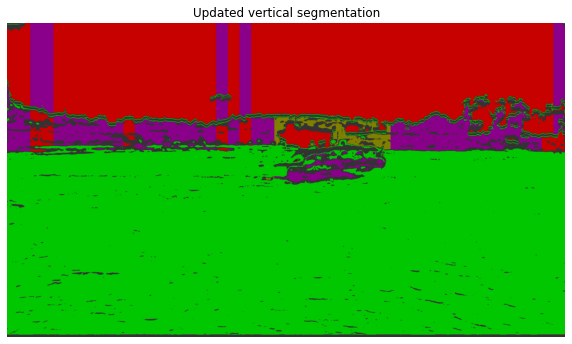

In [31]:
working_updated_colored_image, working_updated_class_map,_ = vertical_separation_pipeline_s(image_index=7)


Vertical segmentation for all images
Using nærme image
Splitting into lists


verticals:  986145
Horizontals:  946423
Unknown:  141032
[Disparity Value, Derivative Value, V index, U index, Label]
Histogram smoothing peak detection approach
Using nærme image
Splitting into lists
verticals:  986145
Horizontals:  946423
Unknown:  141032
[Disparity Value, Derivative Value, V index, U index, Label]


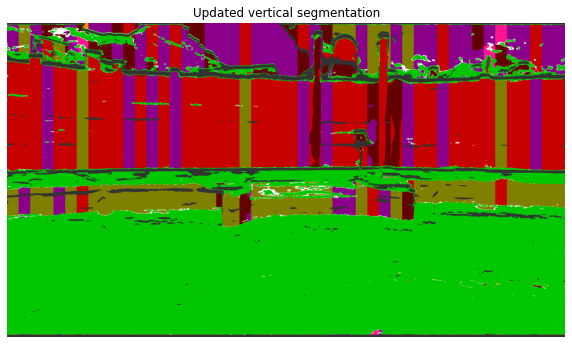

Using første image
Splitting into lists
verticals:  893845
Horizontals:  1057982
Unknown:  121773
[Disparity Value, Derivative Value, V index, U index, Label]
Histogram smoothing peak detection approach
Using første image
Splitting into lists
verticals:  893845
Horizontals:  1057982
Unknown:  121773
[Disparity Value, Derivative Value, V index, U index, Label]


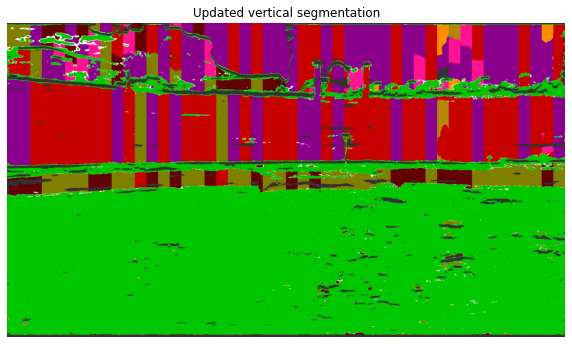

Using badering_første image
Splitting into lists
verticals:  986465
Horizontals:  950394
Unknown:  136741
[Disparity Value, Derivative Value, V index, U index, Label]
Histogram smoothing peak detection approach
Using badering_første image
Splitting into lists
verticals:  986465
Horizontals:  950394
Unknown:  136741
[Disparity Value, Derivative Value, V index, U index, Label]


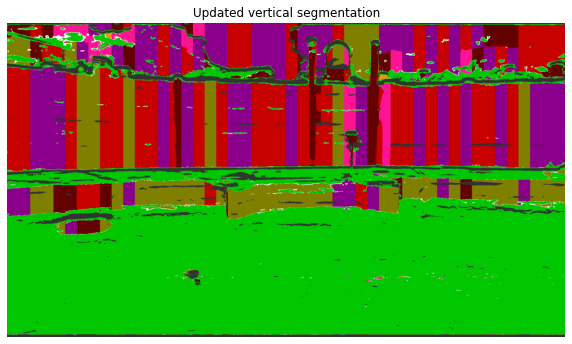

Using badering_mann image
Splitting into lists
verticals:  942471
Horizontals:  1008867
Unknown:  122262
[Disparity Value, Derivative Value, V index, U index, Label]
Histogram smoothing peak detection approach
Using badering_mann image
Splitting into lists
verticals:  942471
Horizontals:  1008867
Unknown:  122262
[Disparity Value, Derivative Value, V index, U index, Label]


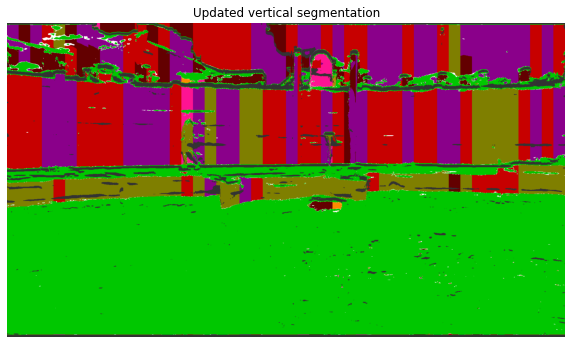

Using båt image
Splitting into lists
verticals:  748968
Horizontals:  1173631
Unknown:  151001
[Disparity Value, Derivative Value, V index, U index, Label]
Histogram smoothing peak detection approach
Using båt image
Splitting into lists
verticals:  748968
Horizontals:  1173631
Unknown:  151001
[Disparity Value, Derivative Value, V index, U index, Label]


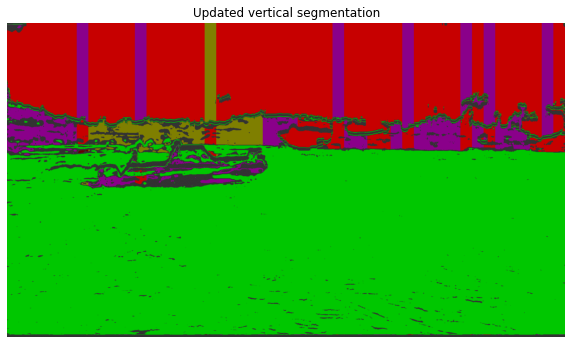

Using kajakk_båt image
Splitting into lists
verticals:  715066
Horizontals:  1202939
Unknown:  155595
[Disparity Value, Derivative Value, V index, U index, Label]
Histogram smoothing peak detection approach
Using kajakk_båt image
Splitting into lists
verticals:  715066
Horizontals:  1202939
Unknown:  155595
[Disparity Value, Derivative Value, V index, U index, Label]


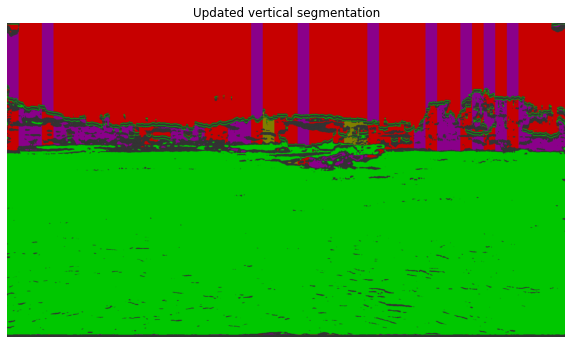

Using båt_bak image
Splitting into lists
verticals:  740357
Horizontals:  1195603
Unknown:  137640
[Disparity Value, Derivative Value, V index, U index, Label]
Histogram smoothing peak detection approach
Using båt_bak image
Splitting into lists
verticals:  740357
Horizontals:  1195603
Unknown:  137640
[Disparity Value, Derivative Value, V index, U index, Label]


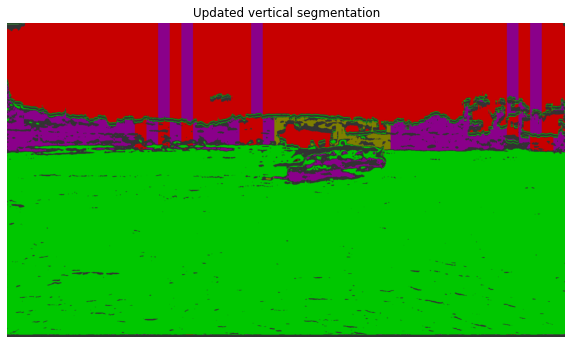

In [33]:
vertical_segment_all_images = True
vertical_segmented_class_maps = []
vertical_segmented_coloured_images = []

if(vertical_segment_all_images):
    print("Vertical segmentation for all images")
    for i in range(1,9):
        working_updated_colored_image, working_updated_class_map,_ = vertical_separation_pipeline_s(image_index=i)
        vertical_segmented_class_maps.append(working_updated_class_map)
        vertical_segmented_coloured_images.append(working_updated_colored_image)


Using båt_fram image
Splitting into lists
verticals:  720731
Horizontals:  1212010
Unknown:  140859
[Disparity Value, Derivative Value, V index, U index, Label]
Histogram smoothing peak detection approach
Using båt_fram image
Splitting into lists
verticals:  720731
Horizontals:  1212010
Unknown:  140859
[Disparity Value, Derivative Value, V index, U index, Label]


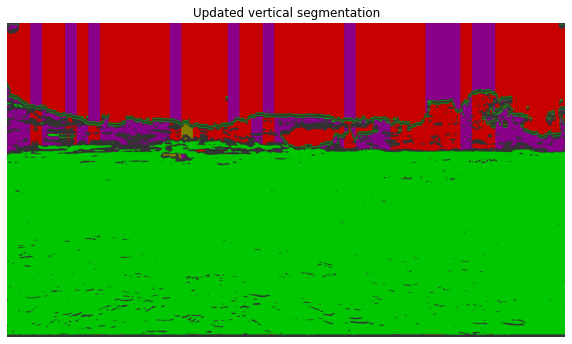

In [35]:
working_updated_colored_image, working_updated_class_map,_ = vertical_separation_pipeline_s(image_index=8)
vertical_segmented_class_maps.append(working_updated_class_map)
vertical_segmented_coloured_images.append(working_updated_colored_image)

In [36]:
print(len(vertical_segmented_coloured_images))
#updated_silhouete_nærme_colored_image, _, _ = vertical_separation_pipeline_s(1, memory_all_num_clusters_n40_nærme, version=1)
#updated_silhouete_badering_colored_image,_,_ = vertical_separation_pipeline_s(3, memory_all_num_clusters_n40_badering, version=1)
#updated_silhouete_mann_colored_image,_,_ = vertical_separation_pipeline_s(4, memory_all_num_clusters_n40_mann, version=1)
#updated_silhouete_båtfram_colored_image,_,_ = vertical_separation_pipeline_s(8, memory_all_num_clusters_n40_båt_fram, version=1)

8


#### Kladding

In [ ]:
# Tar 80 min å kjøre:
kjør_silhouette_flere = False

if(kjør_silhouette_flere):
    cluster_number_for_images = []
    n=40
    for i in [3,4,2]:

        working_image, working_disparity, working_class_map, working_derivative, working_colored_image, working_verticals, working_horizontals = fetch_all_lists_for_image(i)

        striped_vertical_disps = histogram_for_n_columns_vertical(working_divided_vertical_disps, n=n)

        all_number_clusters = all_silhouette_scores(striped_vertical_disps, threshold=0.01, threshold_ratio=0.98, version=2, plot=True, max_clusters=8)

        cluster_number_for_images.append(all_number_clusters)

In [ ]:
#print(all_number_clusters)
"""  
cluster_number_for_images = []
n=40
for i in [3,4,2]:
    

"""
""" for i in range(len(cluster_number_for_images)):
    print("Image number: ", i)
    print("Number of clusters: ", cluster_number_for_images[i])
#print(cluster_number_for_images) """



#memory_all_num_clusters_n40_nærme = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [ ]:

kladding= False

if(kladding):
    plot_the_current_object = True
    do_peak_detection = False
    perform_elbow_metrics = False
    perform_silhouette_metrics = True


    # Clipping values
    a_mini = 0
    a_maxi = 20
    bins = (a_maxi - a_mini)*3
    prom=0.01
    distance=1

    auto_range = (a_mini-2, a_maxi)


    # testing_stripes = [0, 4, 13, 16, 26]
    current_plot_object = striped_vertical_disps[27]

    if(plot_the_current_object):
        plt.figure(figsize=(10,6))
        plt.hist(current_plot_object, bins=150, range=auto_range, alpha=0.6, label='Histogram', density=True)
        plt.xlabel('Disparity Value')
        plt.ylabel('Image v-Axis')
        plt.title('Disparity strips for vertical points')
        plt.show()

    if(do_peak_detection):
        peaks = plot_histogram_with_peaks(current_plot_object, bins=bins, min_prominence=prom, min_distance=distance, auto_range=auto_range, plot=True)

        print("Peaks: ", peaks)




    clipped_disps = current_plot_object
    #clipped_disps = np.clip(current_plot_object, a_min=a_mini, a_max=a_maxi)

    #clipped_disps = clipped_disps[(clipped_disps > a_mini) & (clipped_disps < a_maxi)]



    # Sample data
    X = np.array(clipped_disps).reshape(-1, 1)

    #X = np.array(current_plot_object).reshape(-1, 1)

    if(perform_elbow_metrics):
        # Elbow Method
        wcss = []
        for i in range(1, 11):
            kmeans = KMeans(n_clusters=i, random_state=42)
            kmeans.fit(X)
            wcss.append(kmeans.inertia_)

        plt.plot(range(1, 11), wcss)
        plt.title('Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.show()

    if(perform_silhouette_metrics):
        # Silhouette Method
        silhouette_scores = []
        for i in range(2, 11):
            kmeans = KMeans(n_clusters=i, random_state=42)
            kmeans.fit(X)
            score = silhouette_score(X, kmeans.labels_)
            silhouette_scores.append(score)

        plt.plot(range(2, 11), silhouette_scores)
        plt.title('Silhouette Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('Silhouette Score')
        plt.show()

        threshold_ratio = 0.95
        threshold= 0.01
        max_score = max(silhouette_scores)
        print(f'Maximum Silhouette Score: {max_score}')

        # Step 3: Select the Minimum Number of Clusters within the Threshold
        selected_number_of_clusters = None
        for n_clusters, score in enumerate(silhouette_scores, start=2):
            """ if score >= threshold_ratio * max_score:
                selected_clusters = n_clusters
                break """
            print(f'Number of Clusters: {n_clusters}, Score: {score}')
            if max_score - score < threshold:
                selected_number_of_clusters = n_clusters
                break

        print(f'Selected Number of Clusters: {selected_number_of_clusters}')



        best_silouette_score = max(silhouette_scores)
        second_best_silouette_score = sorted(silhouette_scores)[-2]
        print("Best silhouette score: ", best_silouette_score)
        print("Second best silhouette score: ", second_best_silouette_score)
        best_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
        second_best_num_clusters = silhouette_scores.index(sorted(silhouette_scores)[-2]) + 2
        print("Best number of clusters: ", best_num_clusters)
        print("Second best number of clusters: ", second_best_num_clusters)
        
        if(best_silouette_score - second_best_silouette_score < 0.02):
            print("Warning: The silhouette scores are very close, consider the second best score")
            if(second_best_num_clusters < best_num_clusters):
                print("Second highest is better, using that instead")
                best_num_clusters = second_best_num_clusters

## Horisontal segmentering

### Kolonner til bilder

Nærme kolonner: [730, 1215]


Første kolonner: [550, 1140] 


Badering [250, 1050] 


Mann kolonner: [620, 1100] 


Båt kolonner: [585, 800] 


Kajakk kolonner: [280, 1030] 


Båt bak kolonner: [1100, 1250] 


Båt fram kolonner: [500, 600] 


### Define image and create lists

In [ ]:

# ----------------------------------------------------------------------------------------------------------------------------------------
# Variabler
# ----------------------------------------------------------------------------------------------------------------------------------------

img = båt_fram_image
disp = båt_fram_disparity
current_column = 585

# ----------------------------------------------------------------------------------------------------------------------------------------


surface_split_disparity_image = disp.copy()
kladd_class_map, kladd_colored_image, splitting_derivative = initial_segmentation(img, disp, k_value=3, clustering_bool=False, plot_figures=False)
display_disp_image(kladd_colored_image)

flattened_derivatives = flatten_and_plot_histogram(splitting_derivative, plot=False, title="Histogram of the derivatives")


print("Splitting into lists")
verticals, horizontals = split_into_lists(surface_split_disparity_image, class_map, splitting_derivative)

vertical_Derivative_List, vertical_Disp_List, vertical_Obj_List, divided_vertical_obj_list = verticals
horizontal_Derivative_List, horizontal_Disp_List, horizontal_Obj_List, divided_horizontal_obj_list = horizontals

divided_vertical_disps = create_divided_vertical_disps(divided_vertical_obj_list)

""" print(" Length vertical objects: ",len(vertical_Obj_List))
print("Example of vertical object: ", vertical_Obj_List[0])

print(" Length horizontal objects",len(horizontal_Obj_List))
print("Example of horizontal object: ", horizontal_Obj_List[0])  """



In [ ]:
# View entire disparity data histogram for vertical points:

#display_disp_image(kladd_colored_image)
# Båt : [585, 800]
plt.figure(figsize=(10,6))
plt.hist(horizontal_Disp_List, bins=200, range=(-1,60), alpha=0.6, label='Histogram', density=True)
plt.xlabel('Disparity Value')
plt.ylabel('Image v-Axis')
plt.title('ALL DISPARITIES HISTOGRAM')
plt.show()

print("Length of vertical disparities: ", len(horizontal_Disp_List))

# Del 3 Contour Relaxation

# Del 1,5 GMM (må flyttes)

## Plotting av histogrammer og Gaussian mixtures BURDE FLYTTES TIL DEL 1

#### Fitting GMM


In [ ]:
GMM_TESTING_BOOLEAN = True
img = båt_fram_image
disp = båt_fram_disparity

if(GMM_TESTING_BOOLEAN):
    

    surface_split_disparity_image = disp.copy()
    kladd_class_map, kladd_colored_image, splitting_derivative = initial_segmentation(img, surface_split_disparity_image, clustering_bool=True, plot_figures=False)

    flattened_derivatives = flatten_and_plot_histogram(splitting_derivative, plot=False, title="Histogram of the derivatives")

    min_clip=-0.3    
    max_clip=0.5
    num_curves=2
    num_bins=200
    p=0.05
    k=2
    plot=True
    version=1

    print("Thresholds Clipping verstion")

    regular_clipped_derivatives = np.clip(flattened_derivatives, min_clip, max_clip)
    clipped_derivatives = regular_clipped_derivatives[(regular_clipped_derivatives > min_clip) & (regular_clipped_derivatives < max_clip)]

    hist_values, bin_edges = np.histogram(clipped_derivatives, bins=num_bins, density=True)
    max_frequency = np.max(hist_values)
    threshold = p * max_frequency
    if(plot):
        print("Maximum frequency in the histogram:", max_frequency)
        print(f"Threshold ({p*100}% of max frequency):", threshold)

    # Adjust histogram values: set values below the threshold to 0
    smooth_hist_values = np.where(hist_values < threshold, 0, hist_values)

    """ if(plot):
        # Plot the adjusted histogram
        plt.figure(figsize=(10, 6))
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Calculate bin centers for plotting
        plt.bar(bin_centers, smooth_hist_values, width=(bin_edges[1] - bin_edges[0]), alpha=0.6, color='g', label='Smoothed Histogram')

        plt.legend()
        plt.title('Smoothed Histogram of Clipped Derivatives')
        plt.xlabel('Data Value')
        plt.ylabel('Density')

        plt.show() """

    # Find the indices of non-zero bins in the smoothed histogram 
    non_zero_indices = np.nonzero(smooth_hist_values)[0]

    # Extract the minimum and maximum value along the value axis
    min_value_range = bin_edges[non_zero_indices[0]]
    max_value_range = bin_edges[non_zero_indices[-1] + 1]  # Add 1 to include the right edge of the last bin

    reclipped_derivatives = clipped_derivatives[(clipped_derivatives > min_value_range) & (clipped_derivatives < max_value_range)]  


    ##########################################
    # Regular
    ##########################################
    print("Fitting regular")
    gmm_regular = GaussianMixture(n_components=2, random_state=0)
    gmm_regular.fit(regular_clipped_derivatives.reshape(-1, 1))

    means_regular = gmm_regular.means_.flatten()
    covariances_regular = gmm_regular.covariances_.flatten()
    weights_regular = gmm_regular.weights_.flatten()

    ##########################################
    # Clipped
    ##########################################
    print("Fitting clipped")
    gmm_clipped = GaussianMixture(n_components=2, random_state=0)
    gmm_clipped.fit(clipped_derivatives.reshape(-1, 1))

    means_clipped = gmm_clipped.means_.flatten()
    covariances_clipped = gmm_clipped.covariances_.flatten()
    weights_clipped = gmm_clipped.weights_.flatten()


    ##########################################
    # triple
    ##########################################
    print("Fitting triple")
    gmm_triple = GaussianMixture(n_components=3, random_state=0)
    gmm_triple.fit(clipped_derivatives.reshape(-1, 1))

    means_triple = gmm_triple.means_.flatten()
    covariances_triple = gmm_triple.covariances_.flatten()
    weights_triple = gmm_triple.weights_.flatten()

    ##########################################
    # Four
    ##########################################
    print("Fitting four")
    gmm_four = GaussianMixture(n_components=4, random_state=0)
    gmm_four.fit(clipped_derivatives.reshape(-1, 1))

    means_four = gmm_four.means_.flatten()
    covariances_four = gmm_four.covariances_.flatten()
    weights_four = gmm_four.weights_.flatten()

    ##########################################
    # Five
    ##########################################
    print("Fitting five")
    gmm_five = GaussianMixture(n_components=5, random_state=0)
    gmm_five.fit(clipped_derivatives.reshape(-1, 1))

    means_five = gmm_five.means_.flatten()
    covariances_five = gmm_five.covariances_.flatten()
    weights_five = gmm_five.weights_.flatten()

    ##########################################
    # Six
    ##########################################
    print("Fitting six")
    gmm_six = GaussianMixture(n_components=6, random_state=0)
    gmm_six.fit(clipped_derivatives.reshape(-1, 1))

    means_six = gmm_six.means_.flatten()
    covariances_six = gmm_six.covariances_.flatten()
    weights_six = gmm_six.weights_.flatten()


    ##########################################
    # Reclipped
    ##########################################
    print("Fitting reclipped")
    # Fit a Gaussian Mixture Model with 2 components to the data
    gmm_reclipped = GaussianMixture(n_components=2, random_state=0)
    gmm_reclipped.fit(reclipped_derivatives.reshape(-1, 1))

    # Extract the means, covariances, and weights of the two Gaussians
    means_reclipped = gmm_reclipped.means_.flatten()
    covariances_reclipped = gmm_reclipped.covariances_.flatten()
    weights_reclipped = gmm_reclipped.weights_.flatten()

    ##########################################
    # Reclipped triple
    ##########################################
    print("Fitting reclipped triple")
    gmm_reclipped_triple = GaussianMixture(n_components=3, random_state=0)
    gmm_reclipped_triple.fit(reclipped_derivatives.reshape(-1, 1))

    means_reclipped_triple = gmm_reclipped_triple.means_.flatten()
    covariances_reclipped_triple = gmm_reclipped_triple.covariances_.flatten()
    weights_reclipped_triple = gmm_reclipped_triple.weights_.flatten()

    ##########################################
    # Reclipped four
    ##########################################
    print("Fitting reclipped four")
    gmm_reclipped_four = GaussianMixture(n_components=4, random_state=0)
    gmm_reclipped_four.fit(reclipped_derivatives.reshape(-1, 1))

    means_reclipped_four = gmm_reclipped_four.means_.flatten()
    covariances_reclipped_four = gmm_reclipped_four.covariances_.flatten()
    weights_reclipped_four = gmm_reclipped_four.weights_.flatten()

    print("All done!")

#### Plotting GMM Results

In [ ]:
min_clip=-0.05    
max_clip=0.15
max_y = 80
do_xlim = True
do_ylim = True


if(GMM_TESTING_BOOLEAN):
    # Create a range of x values for plotting
    x_values = np.linspace(min_clip, max_clip, 400)
    # New ploting range
    
    display_disp_image(img)

    ##########################################
    #Regular
    ##########################################

    print("Regular 2 curves")
    print("Regular 2 weights: ", weights_regular)
    gaussian_pdfs_regular = [
        weights_regular[i] * norm.pdf(x_values, means_regular[i], np.sqrt(covariances_regular[i]))
        for i in range(2)
    ]

    # Plot the histogram of the clipped data
    plt.figure(figsize=(10, 6))
    plt.hist(regular_clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_regular):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_regular[i]:.2f}, SD: {np.sqrt(covariances_regular[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Clipped
    ##########################################

    print("Clipped edges 2 curves")
    print("Clipped 2 weights: ", weights_clipped)
    weights_fabricated = [weights_clipped[0], 0.2]
    gaussian_pdfs_clipped = [
        #weights_fabricated[i] * norm.pdf(x_values, means_clipped[i], np.sqrt(covariances_clipped[i]))
        weights_clipped[i] * norm.pdf(x_values, means_clipped[i], np.sqrt(covariances_clipped[i]))
        for i in range(2)
    ]

    plt.figure(figsize=(10, 6))
    plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_clipped):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_clipped[i]:.2f}, SD: {np.sqrt(covariances_clipped[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Triple
    ##########################################
    print("Clipped edges 3 curves")
    print("Clipped 3 weights: ", weights_triple)
    gaussian_pdfs_triple = [
        weights_triple[i] * norm.pdf(x_values, means_triple[i], np.sqrt(covariances_triple[i]))
        for i in range(3)
    ]

    plt.figure(figsize=(10, 6))
    plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_triple):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_triple[i]:.2f}, SD: {np.sqrt(covariances_triple[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Four
    ##########################################
    print("Clipped edges 4 curves")
    print("Clipped 4 weights: ", weights_four)
    gaussian_pdfs_four = [
        weights_four[i] * norm.pdf(x_values, means_four[i], np.sqrt(covariances_four[i]))
        for i in range(4)
    ]

    plt.figure(figsize=(10, 6))
    plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_four):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_four[i]:.2f}, SD: {np.sqrt(covariances_four[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Five
    ##########################################
    print("Clipped edges 5 curves")
    print("Clipped 5 weights: ", weights_five)
    gaussian_pdfs_five = [
        weights_five[i] * norm.pdf(x_values, means_five[i], np.sqrt(covariances_five[i]))
        for i in range(5)
    ]

    plt.figure(figsize=(10, 6))
    plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_five):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_five[i]:.2f}, SD: {np.sqrt(covariances_five[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Six
    ##########################################
    print("Clipped edges 6 curves")
    print("Clipped 6 weights: ", weights_six)
    gaussian_pdfs_six = [
        weights_six[i] * norm.pdf(x_values, means_six[i], np.sqrt(covariances_six[i]))
        for i in range(6)
    ]

    plt.figure(figsize=(10, 6))
    plt.hist(clipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    for i, pdf in enumerate(gaussian_pdfs_six):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_six[i]:.2f}, SD: {np.sqrt(covariances_six[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()


    ##########################################
    # Reclipped
    ##########################################

    print("Reclipped 2 curves")
    print("Reclipped 2 weights: ", weights_reclipped)
    # Calculate the individual Gaussians' PDFs
    gaussian_pdfs_reclipped = [
        weights_reclipped[i] * norm.pdf(x_values, means_reclipped[i], np.sqrt(covariances_reclipped[i]))
        for i in range(2)
    ]

    # Plot the histogram of the clipped data
    plt.figure(figsize=(10, 6))
    plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    # Plot each Gaussian PDF
    for i, pdf in enumerate(gaussian_pdfs_reclipped):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_reclipped[i]:.2f}, SD: {np.sqrt(covariances_reclipped[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Reclipped Triple
    ##########################################

    print("Reclipped 3 curves")
    print("Reclipped 3 weights: ", weights_reclipped_triple)
    # Calculate the individual Gaussians' PDFs
    gaussian_pdfs_reclipped_triple = [
        weights_reclipped_triple[i] * norm.pdf(x_values, means_reclipped_triple[i], np.sqrt(covariances_reclipped_triple[i]))
        for i in range(3)
    ]

    # Plot the histogram of the clipped data
    plt.figure(figsize=(10, 6))
    plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    # Plot each Gaussian PDF
    for i, pdf in enumerate(gaussian_pdfs_reclipped_triple):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_reclipped_triple[i]:.2f}, SD: {np.sqrt(covariances_reclipped_triple[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()

    ##########################################
    # Reclipped Four
    ##########################################
    print("Reclipped 4 curves")
    print("Reclipped 4 weights: ", weights_reclipped_four)
    # Calculate the individual Gaussians' PDFs
    gaussian_pdfs_reclipped_four = [
        weights_reclipped_four[i] * norm.pdf(x_values, means_reclipped_four[i], np.sqrt(covariances_reclipped_four[i]))
        for i in range(4)
    ]

    # Plot the histogram of the clipped data
    plt.figure(figsize=(10, 6))
    plt.hist(reclipped_derivatives, bins=num_bins, range=(min_clip, max_clip), density=True, alpha=0.6, color='goldenrod', label='Data Histogram')
    # Plot each Gaussian PDF
    for i, pdf in enumerate(gaussian_pdfs_reclipped_four):
        plt.plot(x_values, pdf, label=f'Gaussian {i+1} (Mean: {means_reclipped_four[i]:.2f}, SD: {np.sqrt(covariances_reclipped_four[i]):.2f})')
    plt.legend()
    if(do_xlim):
        plt.xlim(min_clip, max_clip)
    if(do_ylim):
        plt.ylim(0, max_y)
    plt.title('Histogram with Individual Fitted Gaussian Distributions')
    plt.xlabel('Derivatives')
    plt.ylabel('Frequency')
    plt.show()



# Del 4 Kladd